<a href="https://colab.research.google.com/github/nowickimichal/nowickimichal/blob/main/multiply_gestures_author_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Screen gestures authors classification using Sklearn library
This notebook presents the classification of the authors of gestures drawn with a stylus on a touch screen. The $ 1 Unistroke set was used for the experiment.

It is necessary to upgrade the sklearn library due to the use of the HalvigRandomSearchCV function (avaiable from 0.24 version)

In [ ]:
!! pip install scikit-learn --upgrade

['Requirement already satisfied: scikit-learn in /usr/local/lib/python3.7/dist-packages (1.0.1)',
 'Requirement already satisfied: scipy>=1.1.0 in /usr/local/lib/python3.7/dist-packages (from scikit-learn) (1.4.1)',
 'Requirement already satisfied: threadpoolctl>=2.0.0 in /usr/local/lib/python3.7/dist-packages (from scikit-learn) (3.0.0)',
 'Requirement already satisfied: numpy>=1.14.6 in /usr/local/lib/python3.7/dist-packages (from scikit-learn) (1.19.5)',
 'Requirement already satisfied: joblib>=0.11 in /usr/local/lib/python3.7/dist-packages (from scikit-learn) (1.1.0)']

Importing nessesary libraries

In [ ]:
import os
import xml.dom.minidom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
from sklearn.tree._classes import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm._classes import SVC,LinearSVC
from sklearn.svm import SVC, NuSVC 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import RidgeClassifier,RidgeClassifierCV,SGDClassifier,Perceptron,PassiveAggressiveClassifier,LogisticRegressionCV,LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn import tree
from scipy import signal
from google.colab import drive

Create lists of classifiers, space of hyperparameters, and list of names

In [ ]:
t = time.time()

clfs=[AdaBoostClassifier,BernoulliNB, DecisionTreeClassifier, ExtraTreeClassifier,
ExtraTreesClassifier, GaussianNB, GaussianProcessClassifier, KNeighborsClassifier, 
LinearSVC, LogisticRegression, MLPClassifier, NuSVC, PassiveAggressiveClassifier,
Perceptron, RandomForestClassifier, RidgeClassifier, SGDClassifier,SVC]

clfsCV=[RidgeClassifierCV, LogisticRegressionCV]

params=[{"n_estimators":[1,10,50,100]}, {"alpha":[0.1,0.5,1,2,10,100]},
        {"max_depth": [3, None]},{"max_depth": [3, None]},
        {"max_depth": [3, None]},{"var_smoothing": [0.001,0.0000001,0,0.000000001]},
        {"max_iter_predict":[1,10,50,100]},{"n_neighbors":[1,3,5]},
        {"C":[0.1,0.5,1,2,10,100]},{"C":[0.1,0.5,1,2,10,100]},
        {"alpha":[0.1,0.5,1,2,10,100]},{"nu":[0.1,0.2,0.5,0.7,0.99]},
        {"C":[0.1,0.5,1,2,10,100]},{"alpha":[0.1,0.5,1,2,10,100]},
        {"n_estimators":[1,10,100,1000]},{"alpha":[0.1,0.5,1,2,10,100]},
        {"alpha":[0.1,0.5,1,2,10,100]},{"C":[0.1,0.5,1,2,10,100]}
        ]

names =['arrow','caret','check','circle','delete_mark','left_curly_brace',
'left_sq_bracket','pigtail','question_mark','rectangle','right_curly_brace',
'right_sq_bracket','star','triangle','v','x']

Conecting to Google Drive where preprocessed gestures are stored in CSV files.

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Thi function implements PCA and creates train and test sets

In [ ]:
def data_processing(path,name):
  df = pd.read_csv(path+'PCA'+name+'_data.csv',index_col=0)
  data=df.drop('0Y',axis=1)
  df_feat = pd.DataFrame(data,columns=df.columns[1:])
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(data,df['0Y'],test_size=0.20,stratify=df['0Y'])
  X_train=X_train.drop('0X',axis=1)
  X_test=X_test.drop('0X',axis=1)
  pca=PCA(200)
  pca.fit(X_train)
  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)
  return (X_test,X_train,y_test,y_train)

Following functions are used to sort results from best to worst.

In [ ]:
def slicer(model):
  x=str(model)
  dot=x.find('.')
  x=x[dot+1:]
  dot=x.find('.')
  x=x[dot+1:]
  dot=x.find('.')
  x=x[dot+1:-2] 
  return(x)
def slicerCV(model): 
  model=(str(model))
  if model=='RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))':
    x='RidgeClassifierCV'
  else:
    x='LogisticRegresionCV'
  return(x)

def proces_params(DICT):
  for param_name, param in DICT.items():
    a=str(param_name)
    b=str(param)
  return (a+' = '+b)

In [ ]:
def sorter(f_scores,n):
  m=0
  sorting_array=np.zeros([int(len(f_scores)/n),2])
  for i in range (0,int(len(f_scores)/n)):
    
    sorting_array[i,0]=i
    sorting_array[i,1]=(float(f_scores[m+4]))
    m=m+n
  sorting_array=(sorting_array[np.lexsort(sorting_array.T)])[:,0]

  new_s=np.zeros([len(sorting_array)],dtype=int)
  for i in range(0,len(sorting_array)):
    new_s[i]=(int(sorting_array[i]))
  new_s=np.flip(new_s)
  m=0
  output=[]
  output.append(';'+'Classifier'+';'+'Best_params'+';'+'F1'+';'+'Accuracy'+';'+'Precision'+';'+'Recall')
 


  if n==6:
    for i in new_s:
      m=i*6
      output.append(';'+f_scores[m]+';'+str(f_scores[m+5])+';'+str(f_scores[m+4])+';'+str(f_scores[m+1])+';'+str(f_scores[m+2])+';'+str(f_scores[m+3]))
    else:
      m=i*5
      output.append(';'+f_scores[m]+';'+str(f_scores[m+4])+';'+str(f_scores[m+1])+';'+str(f_scores[m+2])+';'+str(f_scores[m+3]))
  if output == '[':
    output='RidgeClassifierCV'
  else:
    output=output
  return(output)

In this section gestures are classified and results are saved to CSV files. Confusion matrixes are ploted. 

arrow


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  w

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';PassiveAggressiveClassifier;C = 2;0.94;0.93;0.94;0.93', ';MLPClassifier;alpha = 0.1;0.86;0.86;0.88;0.86', ';LinearSVC;C = 0.5;0.86;0.86;0.88;0.86', ';LogisticRegression;C = 100;0.83;0.83;0.84;0.83', ';Perceptron;alpha = 100;0.81;0.81;0.84;0.81', ';RidgeClassifier;alpha = 10;0.78;0.78;0.8;0.78', ';SVC;C = 0.5;0.74;0.74;0.76;0.74', ';GaussianProcessClassifier;max_iter_predict = 10;0.73;0.74;0.76;0.74', ';SGDClassifier;alpha = 0.1;0.7;0.71;0.72;0.71', ';RandomForestClassifier;n_estimators = 100;0.7;0.71;0.75;0.71', ';KNeighborsClassifier;n_neighbors = 3;0.7;0.71;0.73;0.71', ';GaussianNB;var_smoothing = 1e-07;0.7;0.71;0.76;0.71', ';NuSVC;nu = 0.7;0.64;0.65;0.67;0.65', ';BernoulliNB;alpha = 0.1;0.58;0.6;0.64;0.6', ';ExtraTreesClassifier;max_depth = None;0.54;0.56;0.63;0.56', ';DecisionTreeClassifier;max_depth = None;0.5;0.51;0.5;0.51', ';ExtraTreeClassifier;max_depth = None;0.23;0.24;0.23;0.24', ';AdaBoostClassifier;n_estimators = 1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbf

LogisticRegresionCV
['RidgeClassifierCV', '0.78', '0.8', '0.78', '0.78', 'LogisticRegresionCV', '0.84', '0.86', '0.84', '0.84']
caret


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  w

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';MLPClassifier;alpha = 0.5;0.68;0.69;0.7;0.69', ';SVC;C = 10;0.67;0.68;0.69;0.68', ';PassiveAggressiveClassifier;C = 1;0.67;0.68;0.68;0.68', ';LinearSVC;C = 1;0.67;0.68;0.67;0.68', ';RidgeClassifier;alpha = 2;0.66;0.68;0.68;0.68', ';LogisticRegression;C = 100;0.65;0.66;0.67;0.66', ';RandomForestClassifier;n_estimators = 1000;0.58;0.6;0.62;0.6', ';Perceptron;alpha = 2;0.57;0.59;0.61;0.59', ';GaussianProcessClassifier;max_iter_predict = 50;0.54;0.56;0.56;0.56', ';KNeighborsClassifier;n_neighbors = 5;0.45;0.48;0.45;0.48', ';GaussianNB;var_smoothing = 1e-07;0.45;0.46;0.48;0.46', ';NuSVC;nu = 0.99;0.44;0.48;0.5;0.48', ';BernoulliNB;alpha = 1;0.39;0.37;0.44;0.37', ';ExtraTreesClassifier;max_depth = 3;0.25;0.3;0.25;0.3', ';DecisionTreeClassifier;max_depth = 3;0.25;0.3;0.31;0.3', ';ExtraTreeClassifier;max_depth = None;0.17;0.18;0.19;0.18', ';SGDClassifier;alpha = 10;0.05;0.18;0.03;0.18', ';AdaBoostClassifier;n_estimators = 1;0.05;0.18;0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

LogisticRegresionCV


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


['RidgeClassifierCV', '0.66', '0.68', '0.66', '0.64', 'LogisticRegresionCV', '0.65', '0.67', '0.65', '0.65']
check


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: C

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';NuSVC;nu = 0.2;0.76;0.75;0.79;0.75', ';SVC;C = 1;0.72;0.72;0.76;0.72', ';RidgeClassifier;alpha = 2;0.72;0.72;0.75;0.72', ';MLPClassifier;alpha = 1;0.72;0.71;0.76;0.71', ';LogisticRegression;C = 0.5;0.72;0.72;0.77;0.72', ';KNeighborsClassifier;n_neighbors = 1;0.69;0.69;0.72;0.69', ';GaussianProcessClassifier;max_iter_predict = 100;0.67;0.66;0.71;0.66', ';LinearSVC;C = 0.5;0.65;0.66;0.67;0.66', ';SGDClassifier;alpha = 0.1;0.6;0.62;0.68;0.62', ';Perceptron;alpha = 0.5;0.52;0.53;0.7;0.53', ';ExtraTreesClassifier;max_depth = None;0.48;0.51;0.48;0.51', ';DecisionTreeClassifier;max_depth = None;0.47;0.46;0.52;0.46', ';PassiveAggressiveClassifier;C = 2;0.46;0.5;0.5;0.5', ';GaussianNB;var_smoothing = 1e-09;0.43;0.48;0.5;0.48', ';BernoulliNB;alpha = 0.5;0.4;0.4;0.4;0.4', ';RandomForestClassifier;n_estimators = 10;0.31;0.3;0.39;0.3', ';AdaBoostClassifier;n_estimators = 50;0.25;0.27;0.3;0.27', ';ExtraTreeClassifier;max_depth = None;0.11;0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.72', '0.75', '0.72', '0.72', 'LogisticRegresionCV', '0.71', '0.74', '0.71', '0.71']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


circle


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';LinearSVC;C = 100;0.77;0.78;0.81;0.78', ';RandomForestClassifier;n_estimators = 1000;0.75;0.75;0.77;0.75', ';LogisticRegression;C = 2;0.73;0.74;0.74;0.74', ';KNeighborsClassifier;n_neighbors = 1;0.72;0.74;0.73;0.74', ';GaussianProcessClassifier;max_iter_predict = 50;0.72;0.74;0.75;0.74', ';RidgeClassifier;alpha = 2;0.71;0.72;0.71;0.72', ';MLPClassifier;alpha = 1;0.7;0.71;0.72;0.71', ';PassiveAggressiveClassifier;C = 0.1;0.69;0.72;0.73;0.72', ';SVC;C = 10;0.68;0.71;0.68;0.71', ';Perceptron;alpha = 100;0.64;0.68;0.66;0.68', ';GaussianNB;var_smoothing = 1e-07;0.63;0.63;0.68;0.63', ';NuSVC;nu = 0.7;0.61;0.63;0.63;0.63', ';ExtraTreesClassifier;max_depth = None;0.52;0.54;0.54;0.54', ';BernoulliNB;alpha = 2;0.52;0.53;0.53;0.53', ';DecisionTreeClassifier;max_depth = None;0.41;0.43;0.51;0.43', ';SGDClassifier;alpha = 2;0.39;0.48;0.34;0.48', ';AdaBoostClassifier;n_estimators = 50;0.1;0.18;0.11;0.18', ';ExtraTreeClassifier;max_depth = Non

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

LogisticRegresionCV
['RidgeClassifierCV', '0.69', '0.63', '0.69', '0.66', 'LogisticRegresionCV', '0.78', '0.82', '0.78', '0.78']
delete_mark


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';GaussianNB;var_smoothing = 0.001;0.67;0.66;0.71;0.66', ';LogisticRegression;C = 2;0.62;0.62;0.64;0.62', ';MLPClassifier;alpha = 0.1;0.61;0.62;0.61;0.62', ';RidgeClassifier;alpha = 0.5;0.6;0.62;0.66;0.62', ';PassiveAggressiveClassifier;C = 10;0.59;0.6;0.62;0.6', ';RandomForestClassifier;n_estimators = 1000;0.57;0.59;0.65;0.59', ';LinearSVC;C = 10;0.55;0.57;0.56;0.57', ';SVC;C = 2;0.54;0.56;0.56;0.56', ';GaussianProcessClassifier;max_iter_predict = 10;0.48;0.5;0.55;0.49', ';Perceptron;alpha = 100;0.45;0.43;0.49;0.43', ';BernoulliNB;alpha = 1;0.41;0.43;0.47;0.43', ';KNeighborsClassifier;n_neighbors = 3;0.38;0.4;0.41;0.4', ';NuSVC;nu = 0.7;0.37;0.39;0.42;0.39', ';ExtraTreesClassifier;max_depth = None;0.33;0.36;0.37;0.36', ';DecisionTreeClassifier;max_depth = None;0.32;0.33;0.38;0.33', ';SGDClassifier;alpha = 0.5;0.28;0.33;0.31;0.33', ';ExtraTreeClassifier;max_depth = None;0.12;0.12;0.13;0.12', ';AdaBoostClassifier;n_estimators = 50

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.63', '0.67', '0.63', '0.61', 'LogisticRegresionCV', '0.63', '0.66', '0.63', '0.64']
left_curly_brace


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';LinearSVC;C = 2;0.86;0.86;0.87;0.86', ';LogisticRegression;C = 1;0.81;0.81;0.83;0.81', ';PassiveAggressiveClassifier;C = 1;0.8;0.8;0.81;0.8', ';MLPClassifier;alpha = 1;0.78;0.78;0.8;0.78', ';RidgeClassifier;alpha = 2;0.75;0.75;0.79;0.75', ';SVC;C = 1;0.73;0.74;0.76;0.74', ';Perceptron;alpha = 0.1;0.73;0.74;0.77;0.74', ';RandomForestClassifier;n_estimators = 100;0.69;0.69;0.72;0.69', ';NuSVC;nu = 0.7;0.69;0.71;0.75;0.71', ';KNeighborsClassifier;n_neighbors = 3;0.66;0.66;0.7;0.66', ';GaussianProcessClassifier;max_iter_predict = 1;0.65;0.66;0.69;0.66', ';GaussianNB;var_smoothing = 1e-07;0.54;0.54;0.67;0.54', ';ExtraTreesClassifier;max_depth = None;0.54;0.54;0.58;0.54', ';SGDClassifier;alpha = 2;0.52;0.57;0.57;0.57', ';BernoulliNB;alpha = 1;0.47;0.46;0.5;0.46', ';DecisionTreeClassifier;max_depth = 3;0.3;0.37;0.34;0.37', ';AdaBoostClassifier;n_estimators = 10;0.07;0.15;0.04;0.15', ';ExtraTreeClassifier;max_depth = 3;0.02;0.09;0.01;0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.77', '0.8', '0.77', '0.77', 'LogisticRegresionCV', '0.81', '0.83', '0.81', '0.81']
left_sq_bracket


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';SVC;C = 10;0.67;0.68;0.69;0.68', ';RandomForestClassifier;n_estimators = 1000;0.66;0.66;0.68;0.66', ';RidgeClassifier;alpha = 2;0.63;0.65;0.69;0.65', ';MLPClassifier;alpha = 2;0.62;0.63;0.64;0.63', ';LinearSVC;C = 10;0.61;0.62;0.63;0.62', ';Perceptron;alpha = 0.5;0.6;0.62;0.6;0.62', ';LogisticRegression;C = 10;0.6;0.62;0.62;0.62', ';GaussianProcessClassifier;max_iter_predict = 50;0.55;0.56;0.56;0.56', ';PassiveAggressiveClassifier;C = 1;0.54;0.56;0.61;0.56', ';KNeighborsClassifier;n_neighbors = 1;0.54;0.54;0.58;0.54', ';NuSVC;nu = 0.7;0.53;0.54;0.54;0.54', ';BernoulliNB;alpha = 10;0.47;0.46;0.52;0.46', ';GaussianNB;var_smoothing = 1e-07;0.44;0.43;0.49;0.43', ';ExtraTreesClassifier;max_depth = None;0.42;0.42;0.43;0.42', ';AdaBoostClassifier;n_estimators = 100;0.27;0.31;0.49;0.31', ';DecisionTreeClassifier;max_depth = 3;0.2;0.3;0.23;0.3', ';ExtraTreeClassifier;max_depth = 3;0.04;0.09;0.02;0.09', ';SGDClassifier;alpha = 10;0.01;0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

LogisticRegresionCV
['RidgeClassifierCV', '0.63', '0.65', '0.63', '0.6', 'LogisticRegresionCV', '0.62', '0.63', '0.62', '0.61']
pigtail


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';LogisticRegression;C = 10;0.7;0.71;0.72;0.71', ';MLPClassifier;alpha = 0.5;0.69;0.69;0.7;0.69', ';SVC;C = 100;0.67;0.66;0.71;0.66', ';LinearSVC;C = 2;0.67;0.68;0.68;0.68', ';GaussianProcessClassifier;max_iter_predict = 50;0.66;0.68;0.72;0.68', ';RidgeClassifier;alpha = 0.5;0.64;0.65;0.68;0.65', ';PassiveAggressiveClassifier;C = 10;0.63;0.65;0.69;0.65', ';Perceptron;alpha = 10;0.62;0.65;0.64;0.65', ';NuSVC;nu = 0.7;0.57;0.59;0.62;0.59', ';KNeighborsClassifier;n_neighbors = 3;0.55;0.57;0.62;0.57', ';ExtraTreesClassifier;max_depth = None;0.42;0.43;0.5;0.43', ';SGDClassifier;alpha = 0.5;0.41;0.45;0.5;0.45', ';DecisionTreeClassifier;max_depth = None;0.39;0.39;0.47;0.39', ';GaussianNB;var_smoothing = 1e-09;0.34;0.34;0.49;0.34', ';RandomForestClassifier;n_estimators = 10;0.32;0.33;0.35;0.33', ';BernoulliNB;alpha = 0.5;0.21;0.22;0.2;0.22', ';AdaBoostClassifier;n_estimators = 50;0.11;0.21;0.13;0.21', ';ExtraTreeClassifier;max_depth = 3;

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

LogisticRegresionCV
['RidgeClassifierCV', '0.6', '0.6', '0.6', '0.57', 'LogisticRegresionCV', '0.66', '0.65', '0.66', '0.64']
question_mark


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';LogisticRegression;C = 2;0.91;0.9;0.93;0.9', ';RidgeClassifier;alpha = 2;0.89;0.89;0.92;0.89', ';PassiveAggressiveClassifier;C = 0.1;0.89;0.89;0.91;0.89', ';MLPClassifier;alpha = 0.1;0.89;0.89;0.91;0.89', ';GaussianNB;var_smoothing = 0.001;0.87;0.87;0.88;0.87', ';SVC;C = 1;0.83;0.83;0.85;0.83', ';RandomForestClassifier;n_estimators = 1000;0.83;0.83;0.87;0.83', ';LinearSVC;C = 100;0.83;0.84;0.84;0.84', ';Perceptron;alpha = 0.1;0.8;0.81;0.85;0.81', ';GaussianProcessClassifier;max_iter_predict = 10;0.8;0.8;0.83;0.8', ';NuSVC;nu = 0.5;0.79;0.8;0.82;0.8', ';SGDClassifier;alpha = 0.1;0.74;0.74;0.8;0.74', ';KNeighborsClassifier;n_neighbors = 1;0.73;0.74;0.75;0.74', ';ExtraTreesClassifier;max_depth = None;0.6;0.6;0.69;0.6', ';BernoulliNB;alpha = 0.5;0.59;0.6;0.62;0.6', ';DecisionTreeClassifier;max_depth = None;0.5;0.51;0.52;0.51', ';ExtraTreeClassifier;max_depth = None;0.13;0.15;0.12;0.15', ';AdaBoostClassifier;n_estimators = 100;0.1;0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.81', '0.86', '0.81', '0.8', 'LogisticRegresionCV', '0.9', '0.92', '0.9', '0.9']
rectangle


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';SVC;C = 100;0.84;0.84;0.87;0.84', ';NuSVC;nu = 0.2;0.81;0.81;0.84;0.81', ';MLPClassifier;alpha = 0.1;0.77;0.77;0.81;0.77', ';RidgeClassifier;alpha = 2;0.73;0.75;0.77;0.75', ';Perceptron;alpha = 10;0.72;0.72;0.78;0.72', ';LinearSVC;C = 10;0.7;0.72;0.77;0.72', ';LogisticRegression;C = 10;0.68;0.71;0.76;0.71', ';PassiveAggressiveClassifier;C = 0.5;0.67;0.66;0.75;0.66', ';GaussianProcessClassifier;max_iter_predict = 50;0.67;0.68;0.74;0.68', ';KNeighborsClassifier;n_neighbors = 1;0.55;0.57;0.62;0.57', ';RandomForestClassifier;n_estimators = 100;0.52;0.53;0.54;0.53', ';ExtraTreesClassifier;max_depth = None;0.47;0.5;0.51;0.49', ';SGDClassifier;alpha = 1;0.45;0.51;0.46;0.51', ';BernoulliNB;alpha = 0.1;0.44;0.43;0.52;0.43', ';GaussianNB;var_smoothing = 1e-09;0.41;0.43;0.56;0.43', ';DecisionTreeClassifier;max_depth = None;0.24;0.27;0.26;0.27', ';ExtraTreeClassifier;max_depth = None;0.13;0.15;0.13;0.15', ';AdaBoostClassifier;n_estimators 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.75', '0.78', '0.75', '0.73', 'LogisticRegresionCV', '0.71', '0.76', '0.71', '0.68']
right_curly_brace


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';PassiveAggressiveClassifier;C = 1;0.9;0.9;0.91;0.9', ';LinearSVC;C = 0.1;0.89;0.89;0.9;0.89', ';SVC;C = 10;0.87;0.87;0.88;0.87', ';RidgeClassifier;alpha = 2;0.87;0.87;0.9;0.87', ';MLPClassifier;alpha = 1;0.87;0.87;0.89;0.87', ';GaussianNB;var_smoothing = 0.001;0.86;0.86;0.88;0.86', ';LogisticRegression;C = 10;0.85;0.86;0.87;0.86', ';RandomForestClassifier;n_estimators = 1000;0.83;0.83;0.86;0.83', ';Perceptron;alpha = 100;0.83;0.83;0.87;0.83', ';NuSVC;nu = 0.5;0.81;0.81;0.85;0.81', ';ExtraTreesClassifier;max_depth = None;0.78;0.78;0.83;0.78', ';GaussianProcessClassifier;max_iter_predict = 50;0.74;0.75;0.78;0.75', ';KNeighborsClassifier;n_neighbors = 1;0.73;0.74;0.77;0.74', ';SGDClassifier;alpha = 2;0.66;0.66;0.68;0.66', ';BernoulliNB;alpha = 0.1;0.57;0.57;0.6;0.57', ';DecisionTreeClassifier;max_depth = None;0.56;0.57;0.61;0.57', ';AdaBoostClassifier;n_estimators = 100;0.12;0.18;0.11;0.18', ';ExtraTreeClassifier;max_depth = 3;0.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.89', '0.91', '0.89', '0.89', 'LogisticRegresionCV', '0.86', '0.87', '0.86', '0.85']
right_sq_bracket


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';PassiveAggressiveClassifier;C = 1;0.65;0.66;0.68;0.66', ';NuSVC;nu = 0.7;0.65;0.65;0.69;0.65', ';LogisticRegression;C = 1;0.65;0.66;0.69;0.66', ';SVC;C = 0.5;0.64;0.65;0.68;0.65', ';GaussianProcessClassifier;max_iter_predict = 10;0.63;0.65;0.68;0.65', ';LinearSVC;C = 0.1;0.62;0.65;0.67;0.65', ';RandomForestClassifier;n_estimators = 1000;0.61;0.63;0.65;0.63', ';RidgeClassifier;alpha = 10;0.57;0.6;0.6;0.6', ';Perceptron;alpha = 0.1;0.57;0.59;0.66;0.59', ';GaussianNB;var_smoothing = 1e-07;0.54;0.56;0.59;0.56', ';KNeighborsClassifier;n_neighbors = 1;0.52;0.56;0.53;0.56', ';ExtraTreesClassifier;max_depth = None;0.46;0.48;0.49;0.48', ';SGDClassifier;alpha = 2;0.42;0.46;0.45;0.46', ';BernoulliNB;alpha = 2;0.39;0.4;0.42;0.4', ';DecisionTreeClassifier;max_depth = 3;0.38;0.48;0.33;0.48', ';MLPClassifier;alpha = 10;0.37;0.45;0.32;0.45', ';ExtraTreeClassifier;max_depth = None;0.07;0.07;0.09;0.07', ';AdaBoostClassifier;n_estimators = 100;0.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.68', '0.66', '0.68', '0.65', 'LogisticRegresionCV', '0.72', '0.75', '0.72', '0.71']
star


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';MLPClassifier;alpha = 0.5;0.84;0.84;0.85;0.84', ';LogisticRegression;C = 1;0.83;0.83;0.85;0.83', ';RidgeClassifier;alpha = 1;0.82;0.83;0.84;0.83', ';LinearSVC;C = 2;0.82;0.81;0.84;0.81', ';RandomForestClassifier;n_estimators = 1000;0.8;0.81;0.81;0.81', ';Perceptron;alpha = 2;0.8;0.8;0.83;0.8', ';PassiveAggressiveClassifier;C = 2;0.78;0.78;0.8;0.78', ';SVC;C = 10;0.76;0.77;0.77;0.77', ';NuSVC;nu = 0.5;0.73;0.74;0.74;0.74', ';KNeighborsClassifier;n_neighbors = 1;0.64;0.65;0.67;0.65', ';GaussianProcessClassifier;max_iter_predict = 50;0.64;0.65;0.69;0.65', ';SGDClassifier;alpha = 0.5;0.6;0.62;0.71;0.62', ';ExtraTreesClassifier;max_depth = 3;0.52;0.54;0.57;0.54', ';GaussianNB;var_smoothing = 1e-07;0.5;0.5;0.69;0.5', ';BernoulliNB;alpha = 10;0.43;0.43;0.48;0.43', ';DecisionTreeClassifier;max_depth = None;0.36;0.39;0.35;0.39', ';ExtraTreeClassifier;max_depth = None;0.06;0.06;0.06;0.06', ';AdaBoostClassifier;n_estimators = 10;0.06;0.15

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.81', '0.81', '0.81', '0.81', 'LogisticRegresionCV', '0.77', '0.78', '0.77', '0.76']
triangle


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';RidgeClassifier;alpha = 2;0.82;0.83;0.85;0.83', ';MLPClassifier;alpha = 0.5;0.81;0.81;0.82;0.81', ';LinearSVC;C = 10;0.81;0.81;0.84;0.81', ';LogisticRegression;C = 1;0.79;0.8;0.81;0.8', ';SVC;C = 10;0.78;0.78;0.79;0.78', ';RandomForestClassifier;n_estimators = 1000;0.75;0.77;0.78;0.77', ';NuSVC;nu = 0.1;0.73;0.74;0.74;0.74', ';PassiveAggressiveClassifier;C = 10;0.68;0.69;0.7;0.69', ';KNeighborsClassifier;n_neighbors = 5;0.66;0.66;0.77;0.66', ';GaussianProcessClassifier;max_iter_predict = 10;0.66;0.66;0.69;0.66', ';Perceptron;alpha = 1;0.6;0.6;0.64;0.6', ';GaussianNB;var_smoothing = 1e-07;0.52;0.51;0.59;0.51', ';ExtraTreesClassifier;max_depth = None;0.5;0.51;0.55;0.51', ';SGDClassifier;alpha = 2;0.46;0.5;0.52;0.5', ';BernoulliNB;alpha = 1;0.39;0.39;0.42;0.39', ';DecisionTreeClassifier;max_depth = 3;0.32;0.39;0.36;0.39', ';ExtraTreeClassifier;max_depth = 3;0.07;0.1;0.12;0.1', ';AdaBoostClassifier;n_estimators = 1;0.05;0.15;0.03;0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegresionCV
['RidgeClassifierCV', '0.81', '0.85', '0.81', '0.81', 'LogisticRegresionCV', '0.8', '0.81', '0.8', '0.79']
v


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';MLPClassifier;alpha = 0.1;0.71;0.74;0.72;0.74', ';SVC;C = 10;0.68;0.69;0.69;0.69', ';LogisticRegression;C = 100;0.63;0.63;0.64;0.63', ';LinearSVC;C = 10;0.61;0.65;0.63;0.65', ';RidgeClassifier;alpha = 0.5;0.54;0.57;0.55;0.57', ';PassiveAggressiveClassifier;C = 2;0.54;0.57;0.6;0.57', ';Perceptron;alpha = 0.1;0.53;0.59;0.52;0.59', ';GaussianProcessClassifier;max_iter_predict = 1;0.46;0.48;0.49;0.48', ';KNeighborsClassifier;n_neighbors = 3;0.44;0.48;0.47;0.48', ';NuSVC;nu = 0.99;0.42;0.43;0.42;0.43', ';SGDClassifier;alpha = 2;0.33;0.37;0.36;0.37', ';ExtraTreesClassifier;max_depth = None;0.33;0.33;0.4;0.33', ';BernoulliNB;alpha = 2;0.31;0.31;0.33;0.31', ';GaussianNB;var_smoothing = 1e-09;0.26;0.3;0.29;0.3', ';DecisionTreeClassifier;max_depth = 3;0.26;0.33;0.25;0.33', ';RandomForestClassifier;n_estimators = 10;0.21;0.22;0.21;0.22', ';ExtraTreeClassifier;max_depth = None;0.09;0.1;0.09;0.1', ';AdaBoostClassifier;n_estimators = 1;0.07;

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

LogisticRegresionCV
['RidgeClassifierCV', '0.56', '0.54', '0.56', '0.52', 'LogisticRegresionCV', '0.65', '0.63', '0.65', '0.63']
x


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

[';Classifier;Best_params;F1;Accuracy;Precision;Recall', ';RidgeClassifier;alpha = 2;0.75;0.75;0.77;0.75', ';LinearSVC;C = 1;0.73;0.74;0.75;0.74', ';SVC;C = 10;0.71;0.72;0.72;0.72', ';LogisticRegression;C = 1;0.7;0.71;0.71;0.71', ';MLPClassifier;alpha = 2;0.67;0.68;0.68;0.68', ';PassiveAggressiveClassifier;C = 10;0.65;0.65;0.68;0.65', ';GaussianNB;var_smoothing = 0.001;0.65;0.65;0.67;0.65', ';Perceptron;alpha = 10;0.62;0.63;0.64;0.63', ';RandomForestClassifier;n_estimators = 1000;0.59;0.59;0.65;0.59', ';NuSVC;nu = 0.7;0.58;0.59;0.59;0.59', ';GaussianProcessClassifier;max_iter_predict = 100;0.58;0.57;0.61;0.57', ';KNeighborsClassifier;n_neighbors = 1;0.54;0.53;0.6;0.53', ';ExtraTreesClassifier;max_depth = 3;0.37;0.36;0.47;0.36', ';SGDClassifier;alpha = 0.5;0.36;0.43;0.32;0.43', ';BernoulliNB;alpha = 1;0.35;0.36;0.39;0.36', ';DecisionTreeClassifier;max_depth = 3;0.15;0.21;0.17;0.21', ';ExtraTreeClassifier;max_depth = 3;0.11;0.15;0.16;0.15', ';AdaBoostClassifier;n_estimators = 50;0.1;0.18

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

LogisticRegresionCV
['RidgeClassifierCV', '0.72', '0.76', '0.72', '0.71', 'LogisticRegresionCV', '0.74', '0.79', '0.74', '0.75']


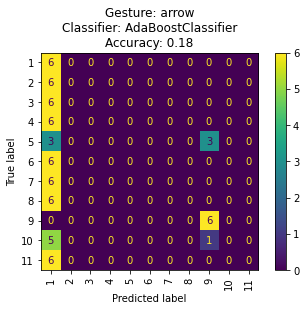

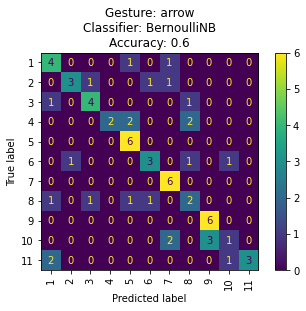

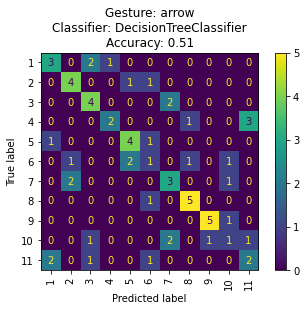

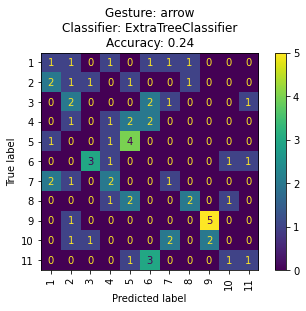

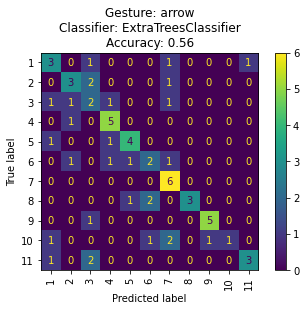

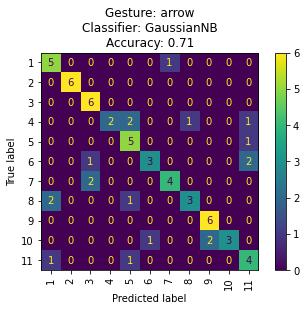

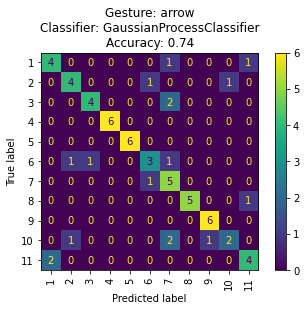

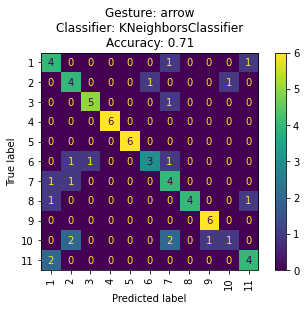

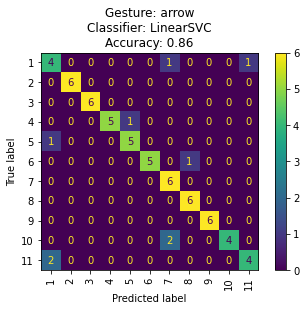

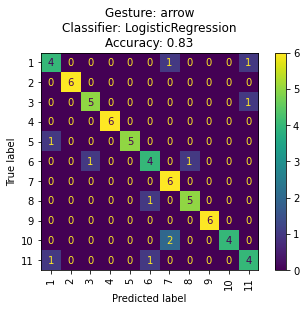

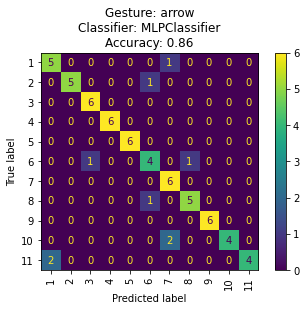

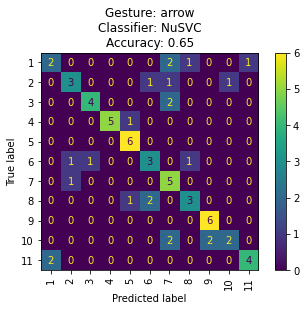

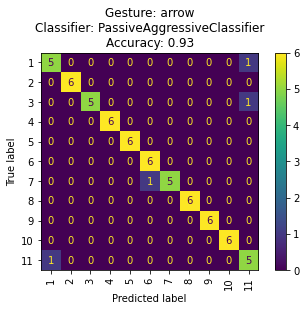

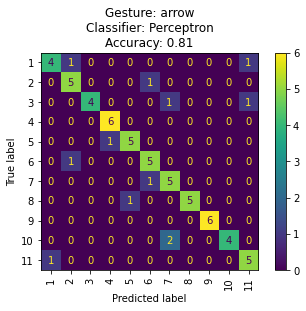

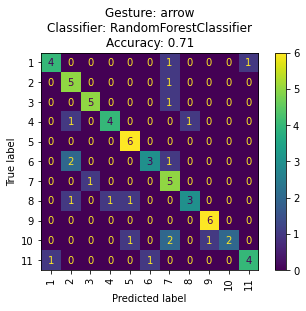

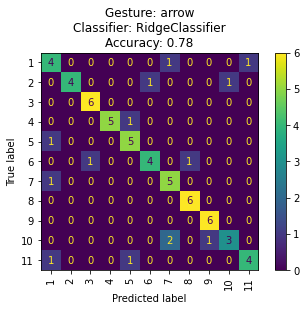

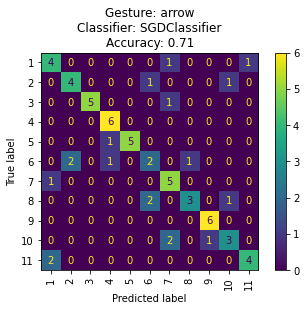

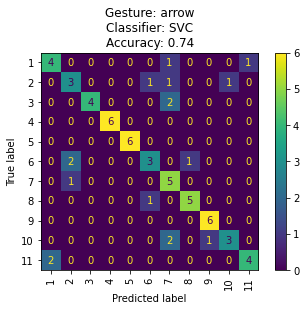

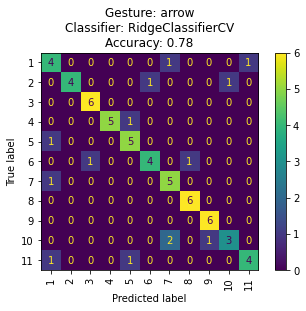

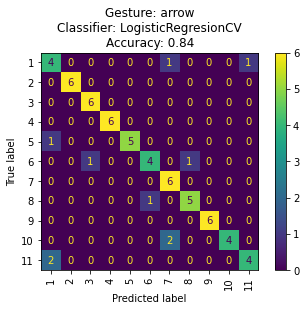

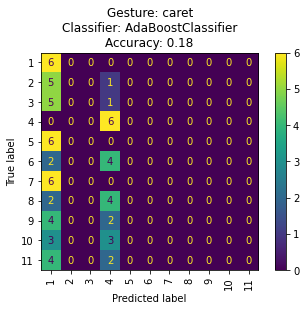

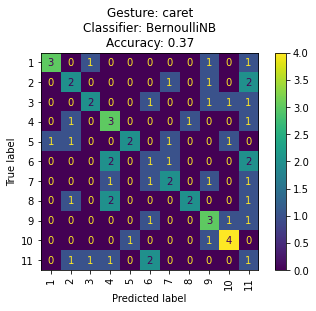

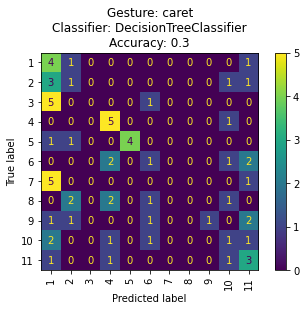

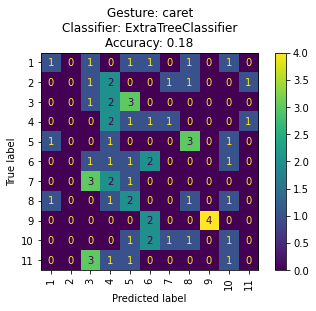

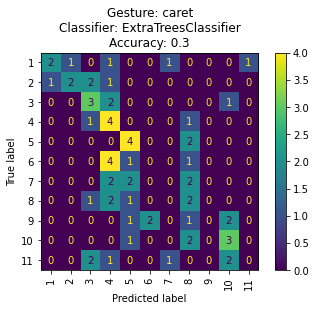

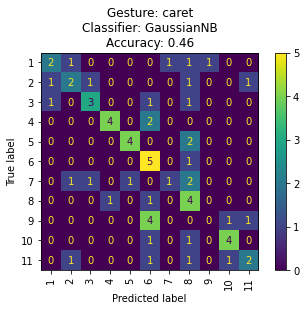

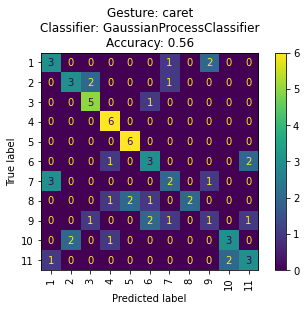

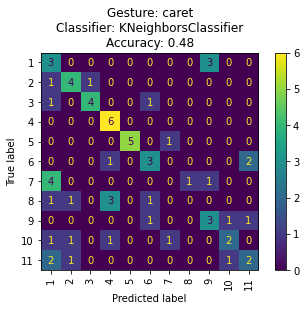

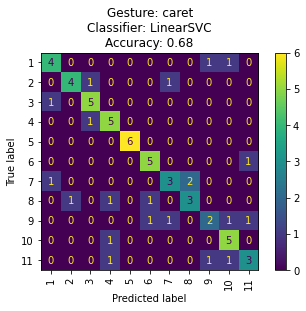

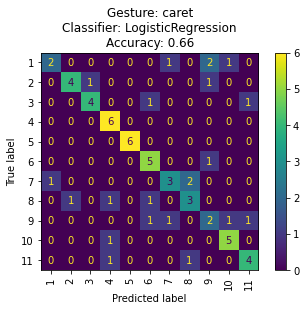

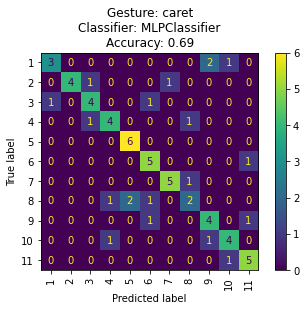

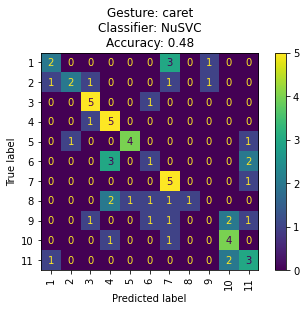

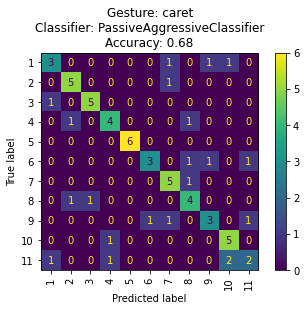

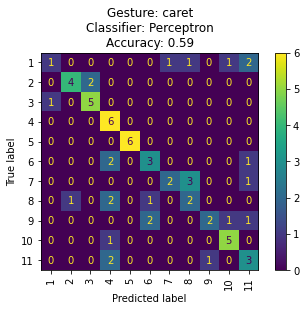

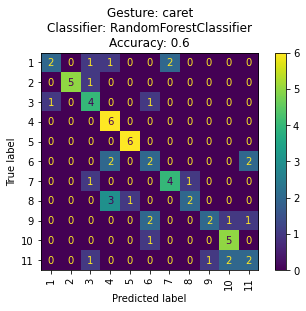

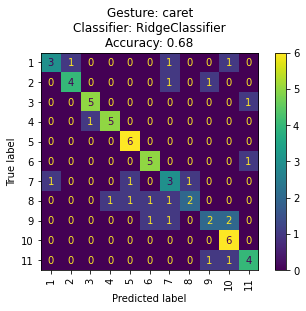

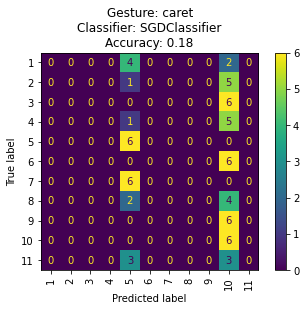

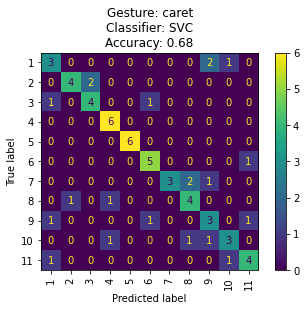

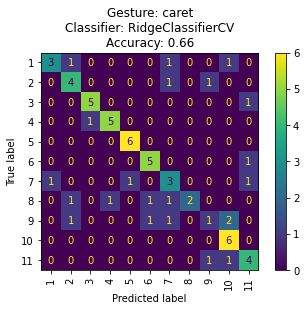

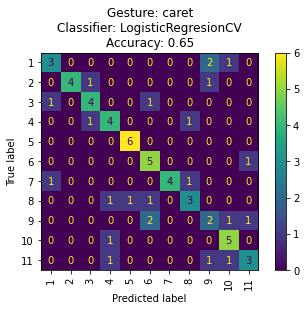

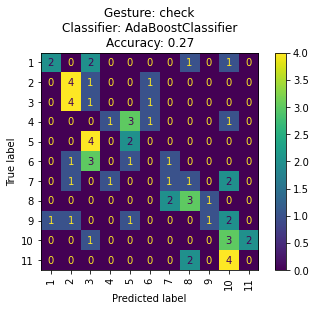

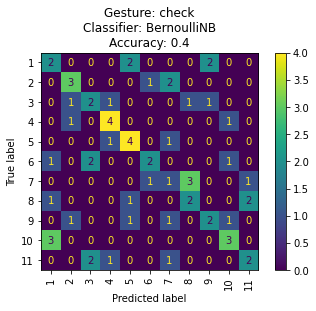

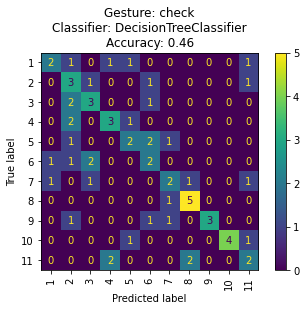

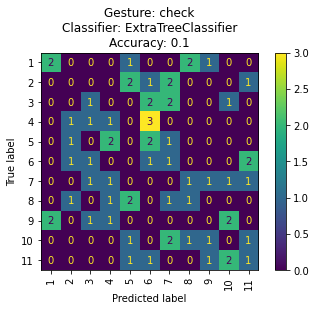

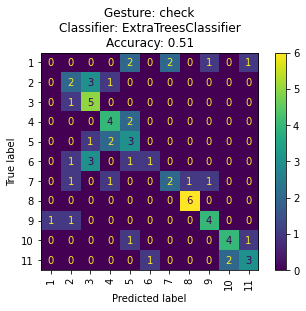

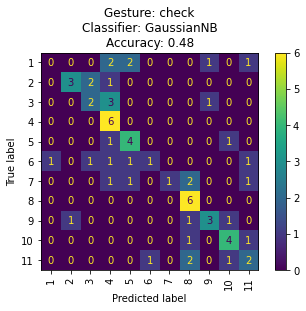

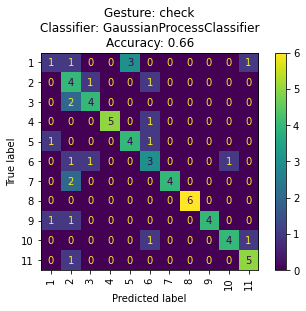

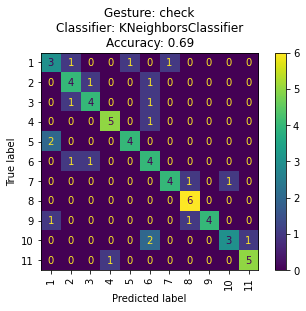

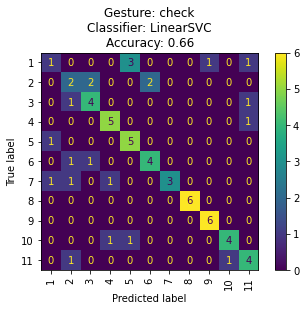

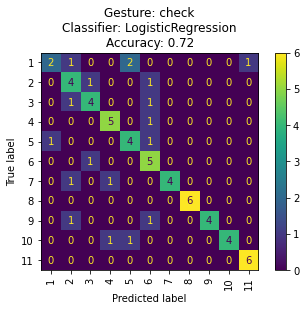

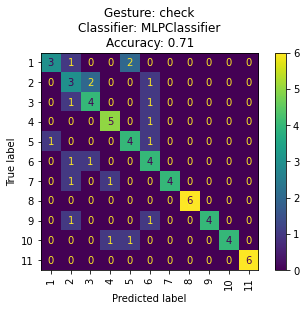

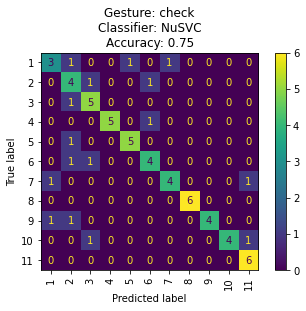

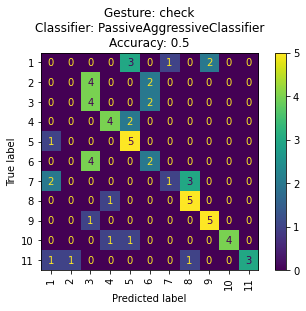

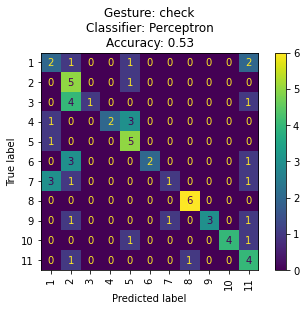

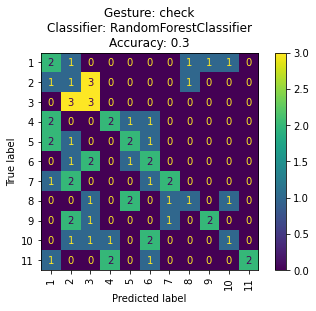

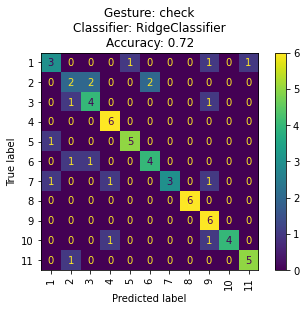

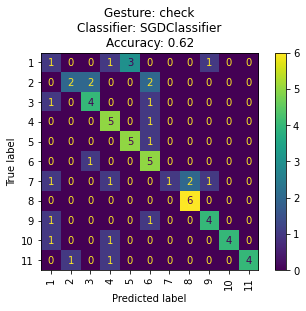

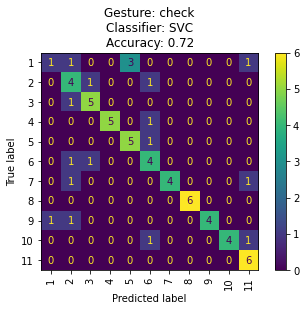

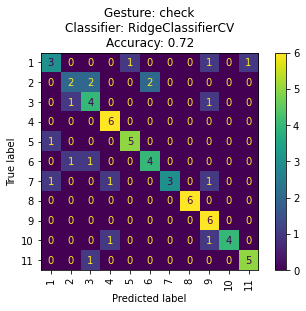

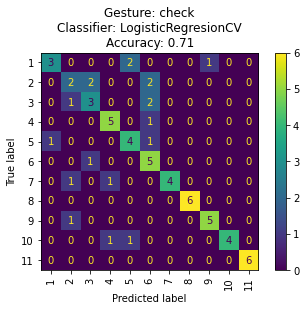

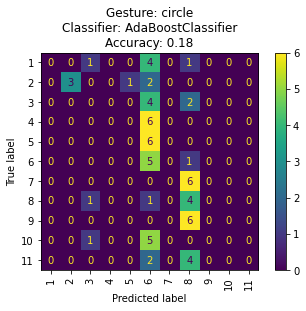

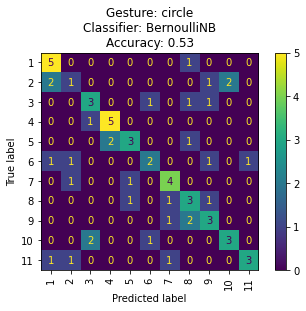

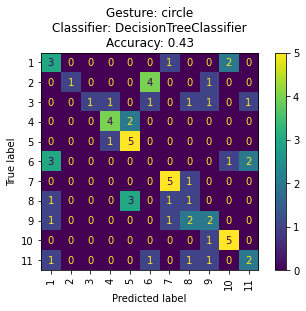

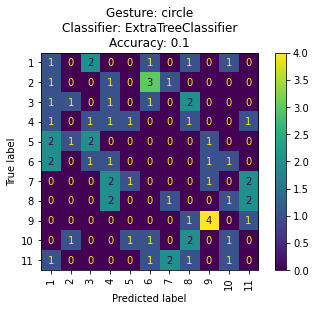

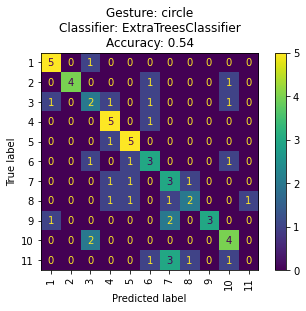

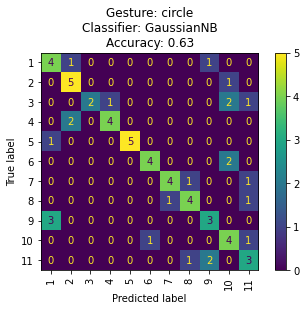

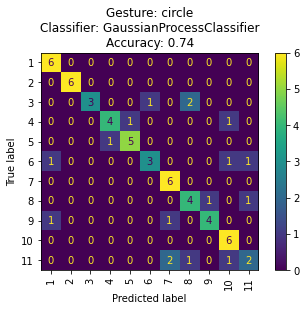

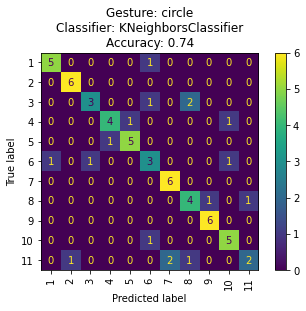

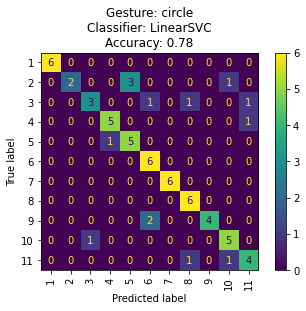

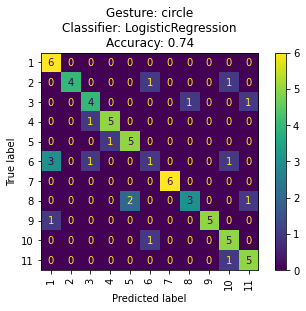

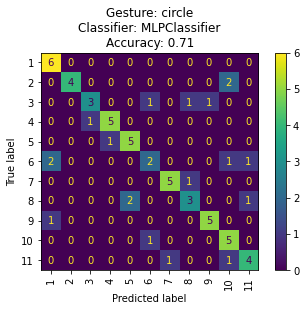

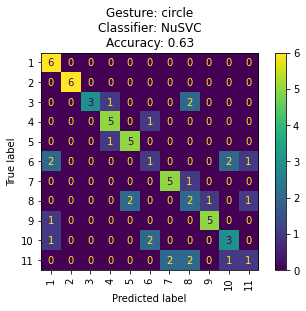

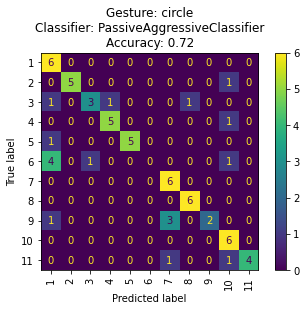

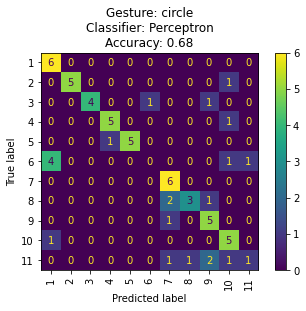

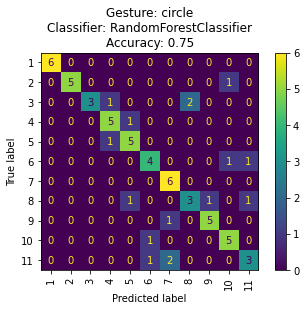

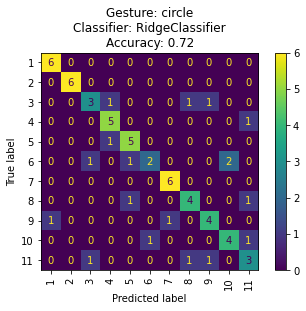

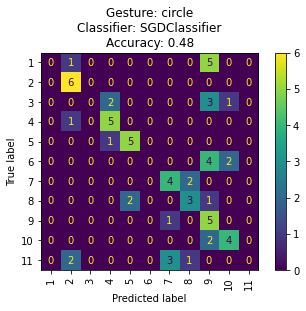

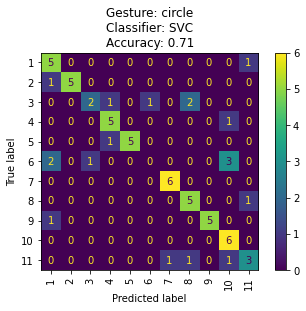

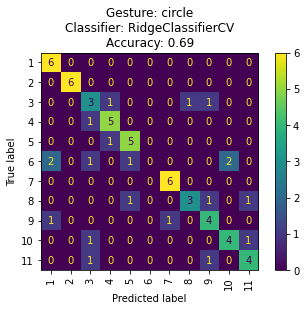

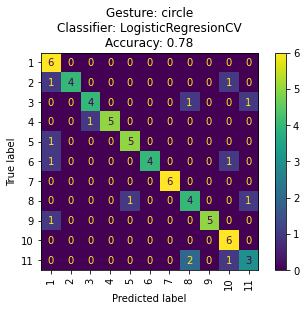

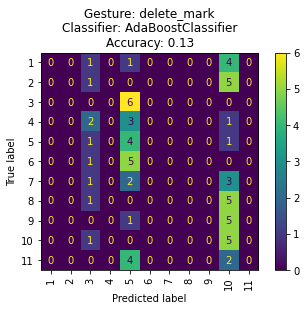

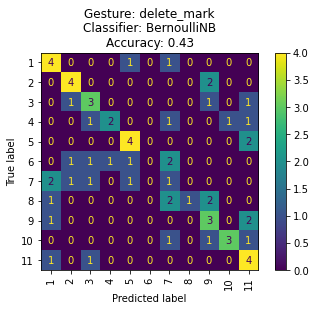

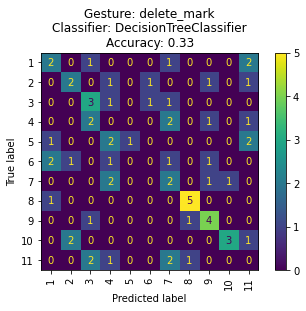

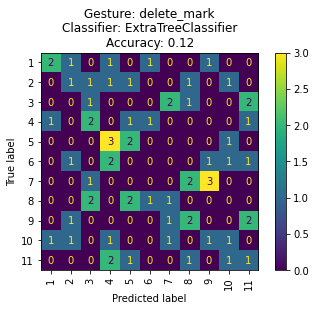

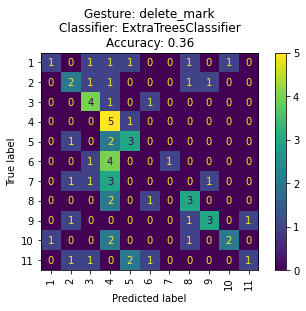

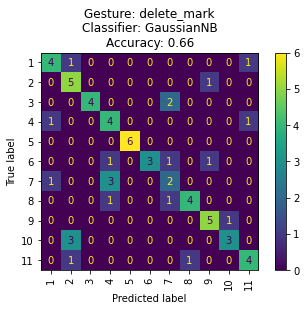

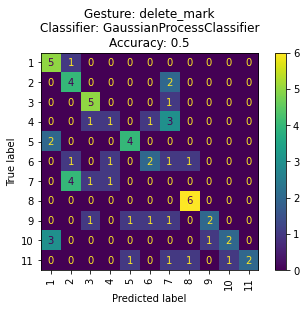

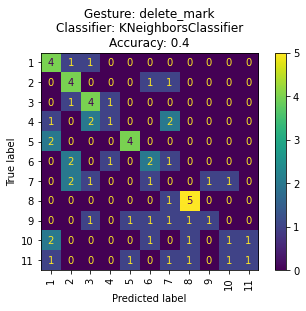

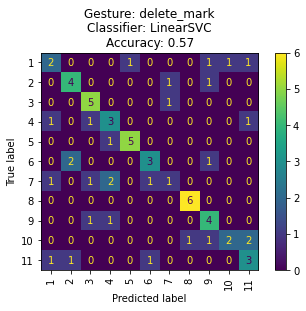

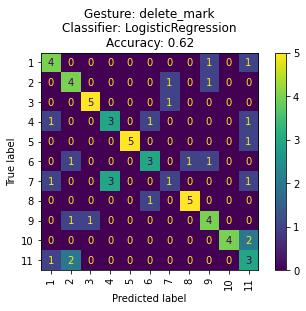

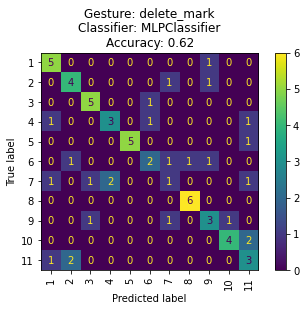

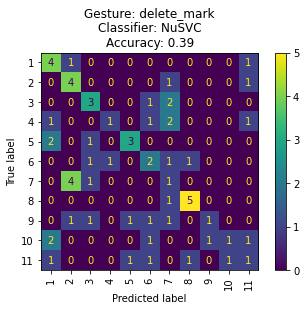

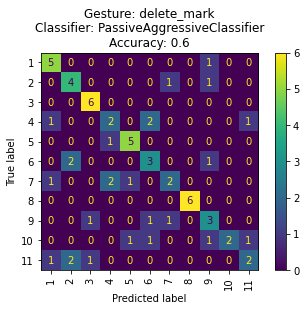

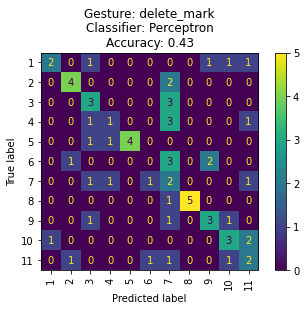

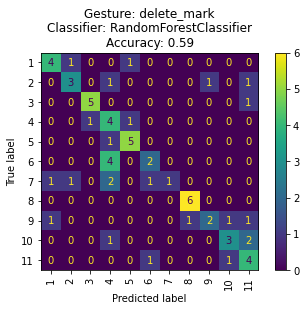

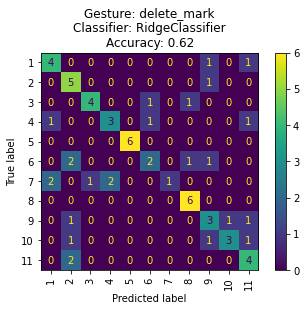

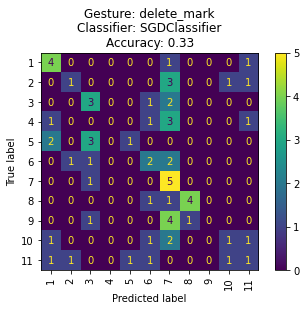

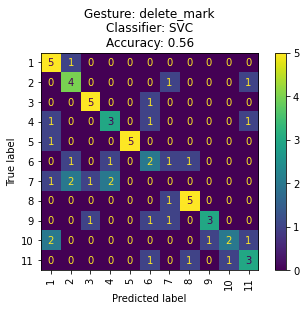

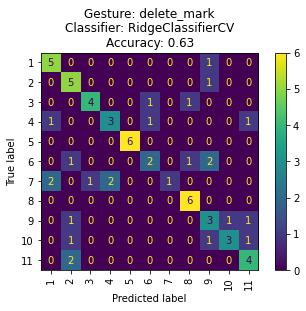

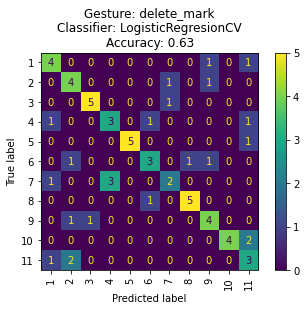

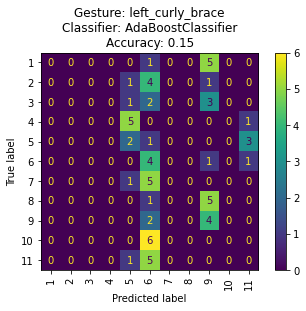

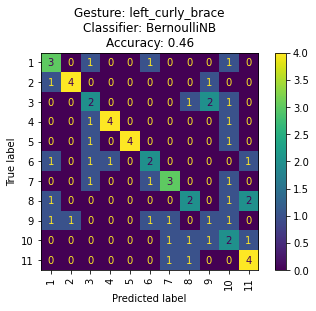

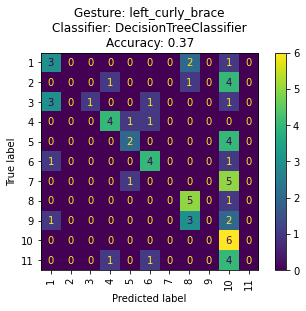

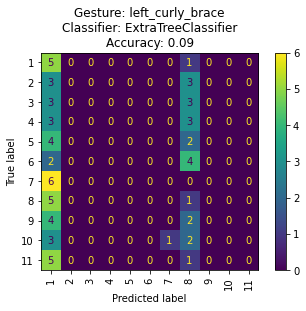

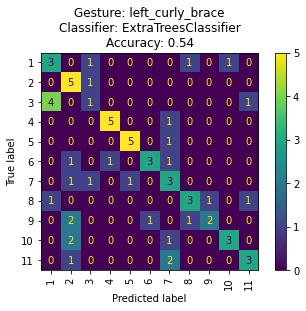

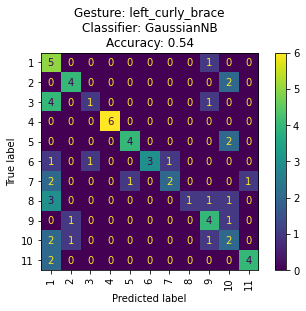

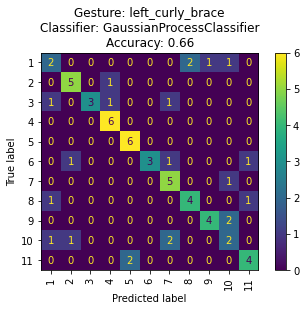

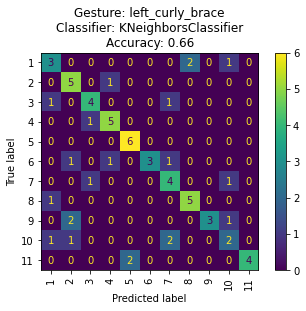

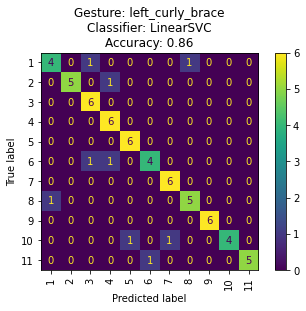

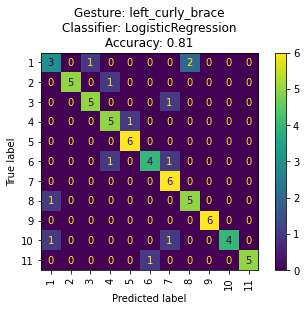

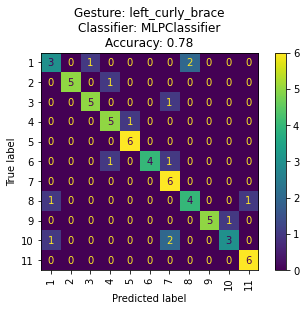

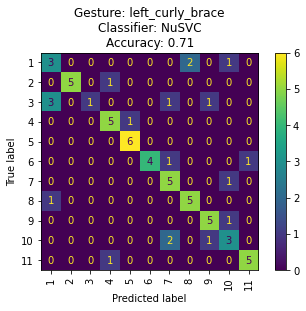

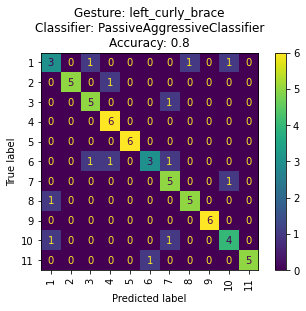

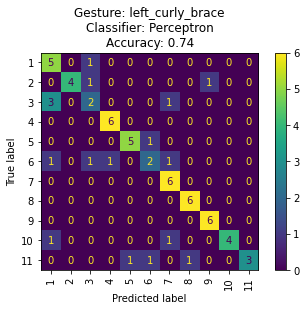

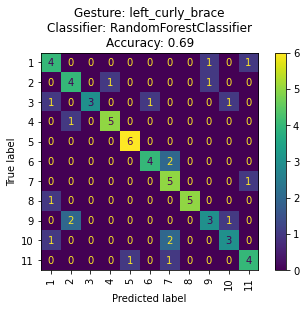

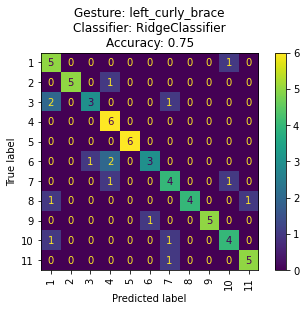

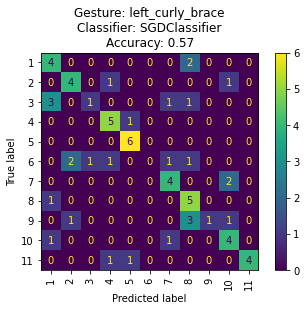

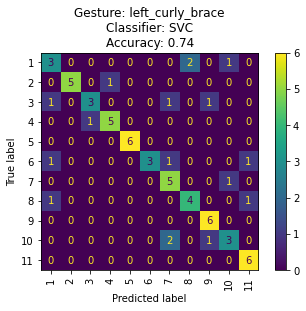

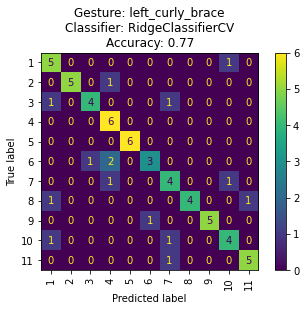

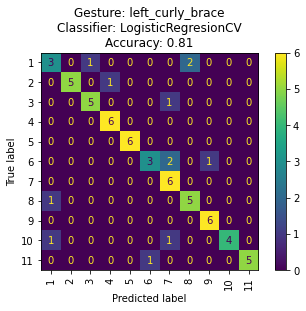

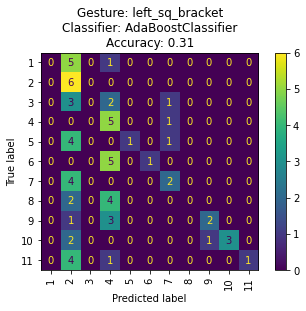

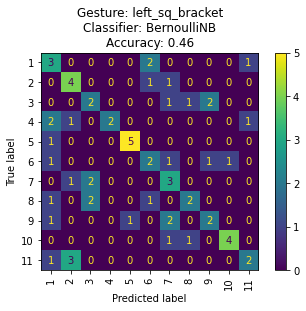

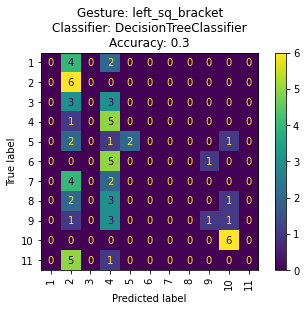

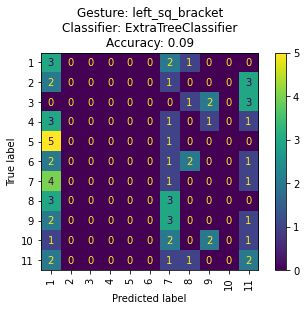

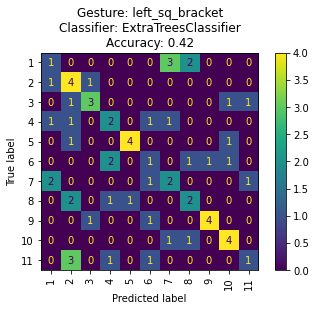

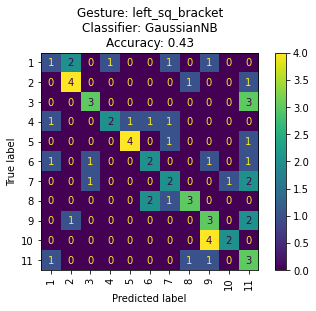

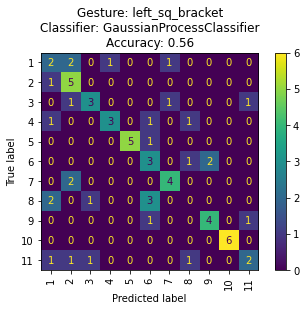

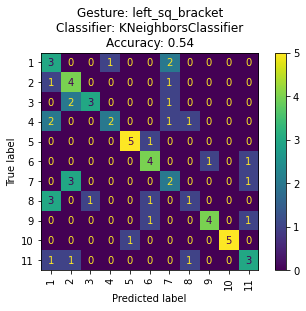

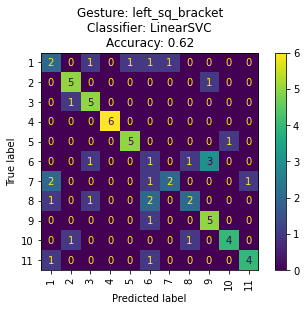

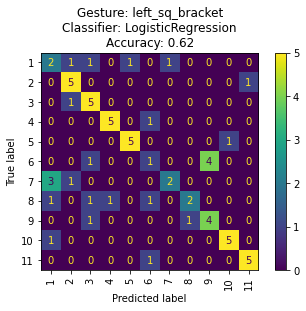

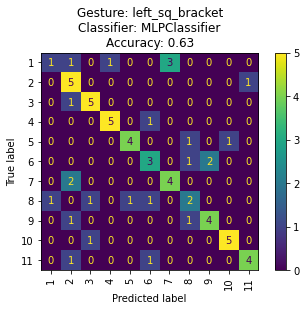

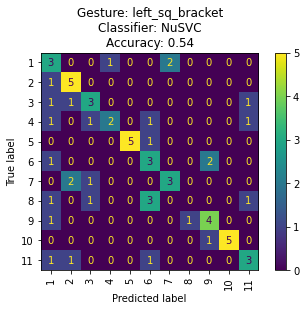

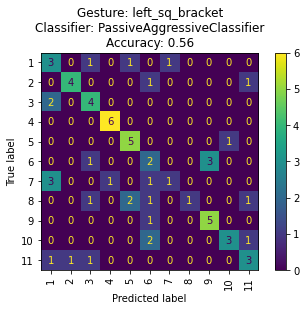

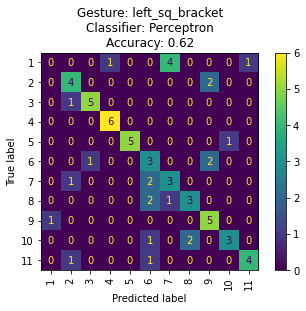

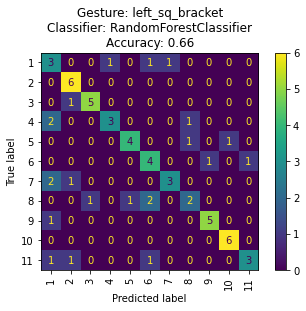

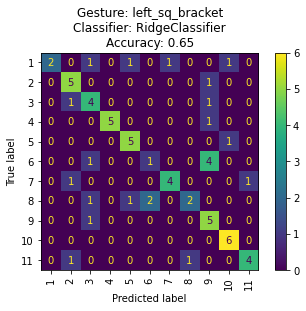

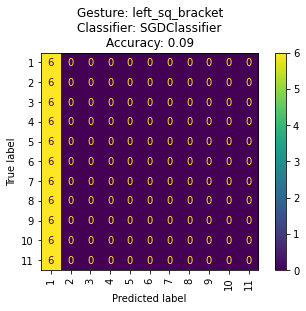

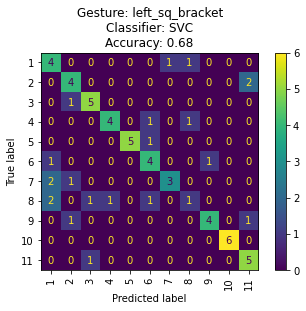

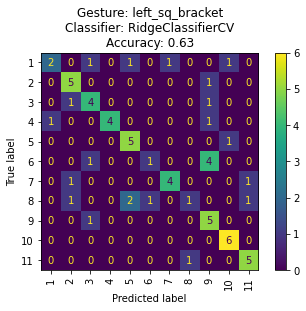

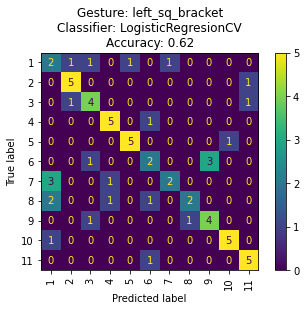

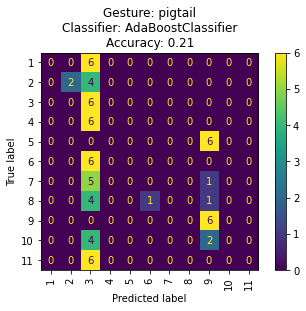

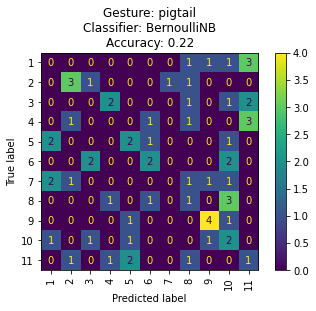

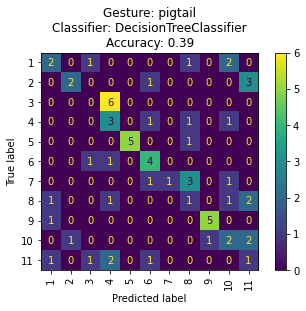

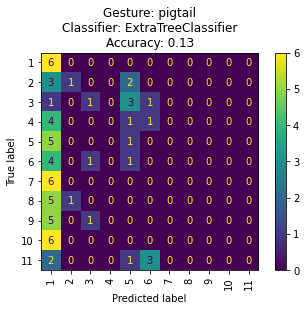

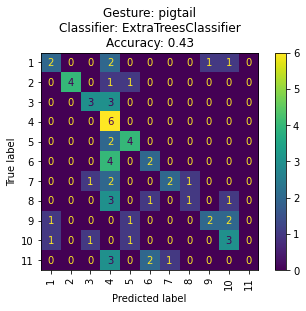

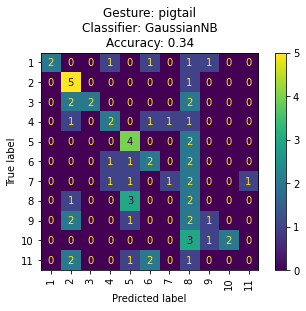

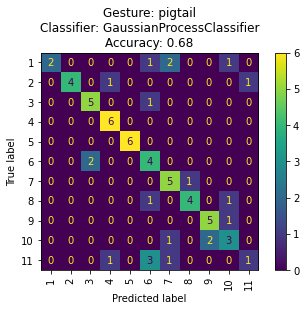

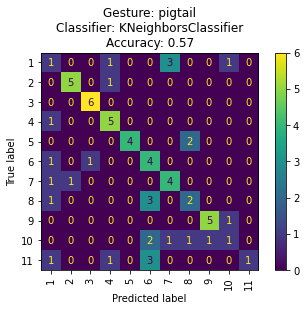

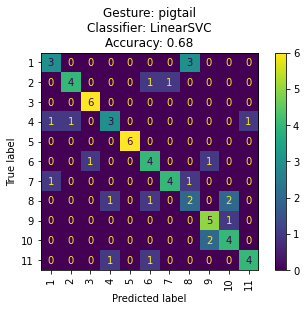

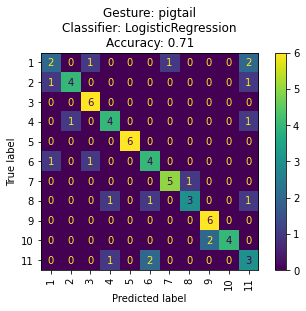

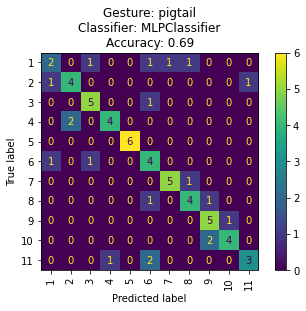

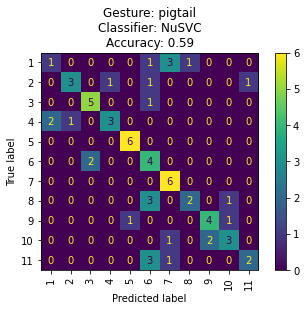

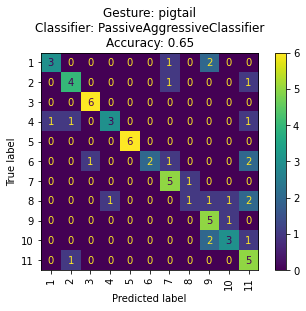

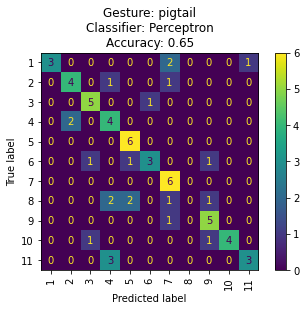

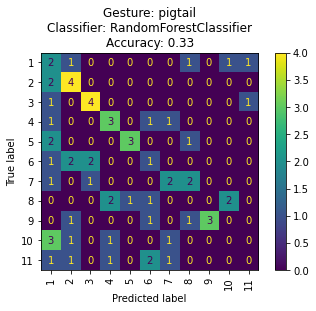

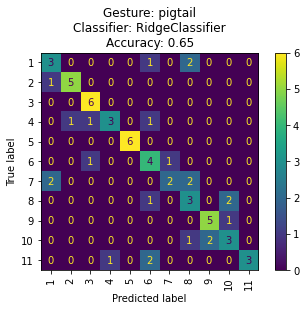

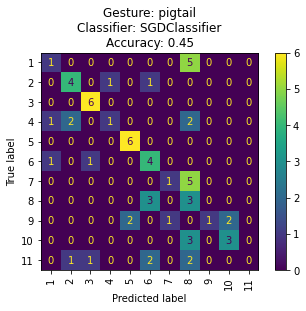

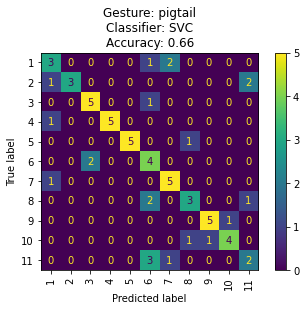

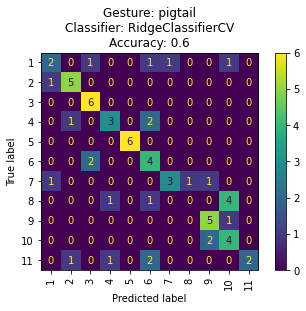

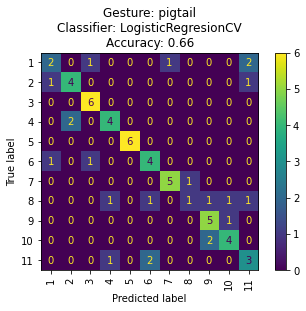

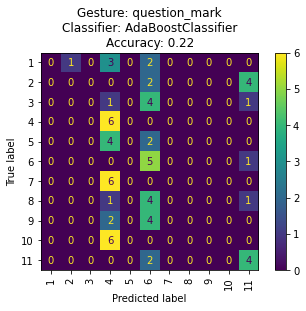

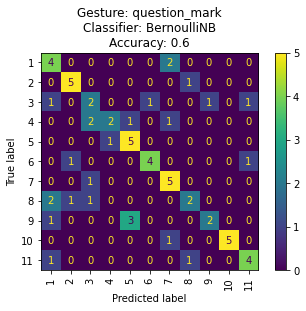

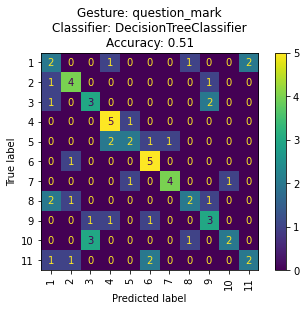

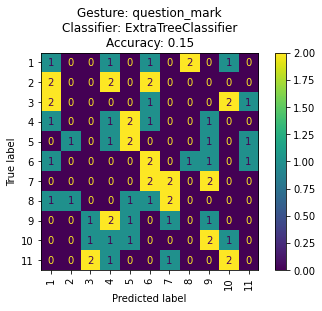

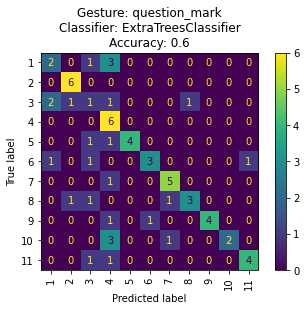

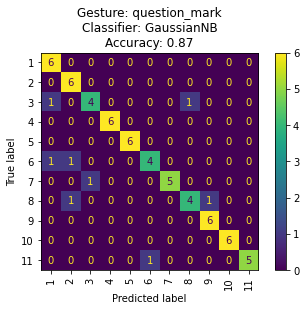

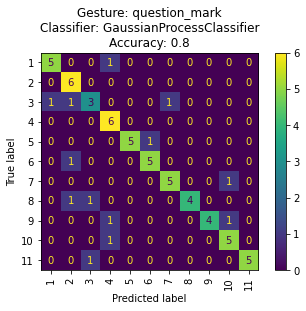

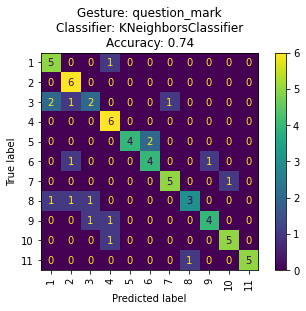

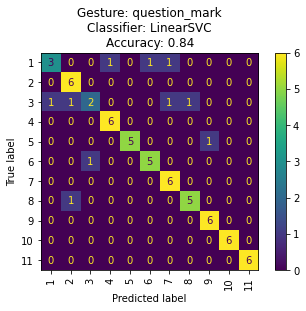

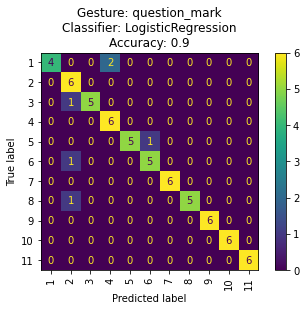

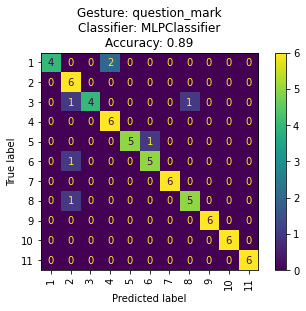

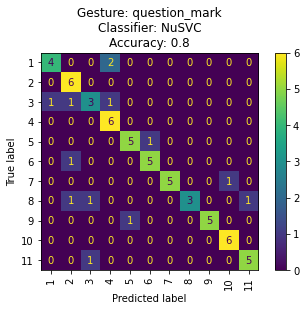

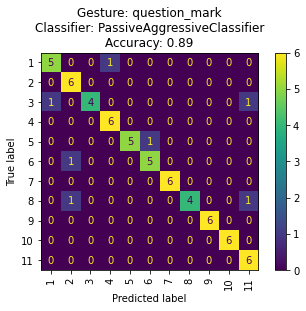

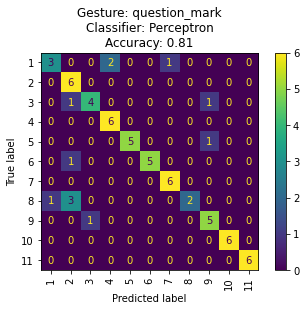

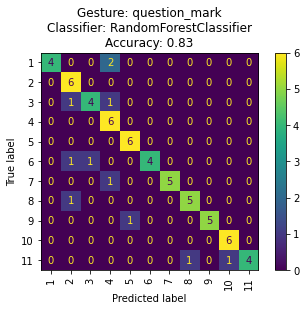

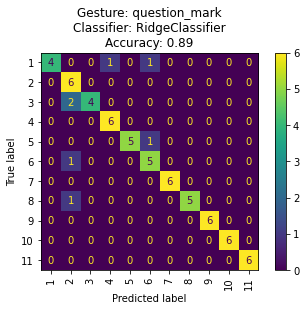

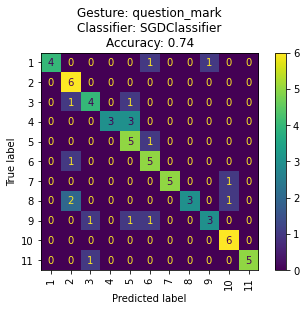

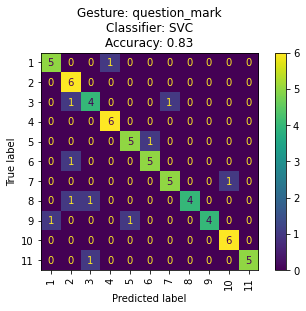

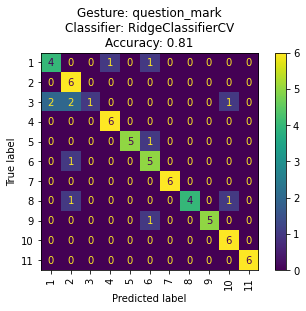

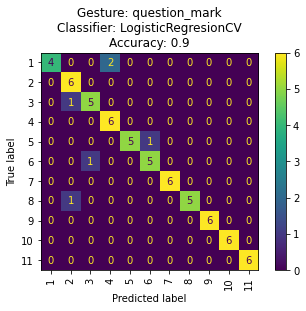

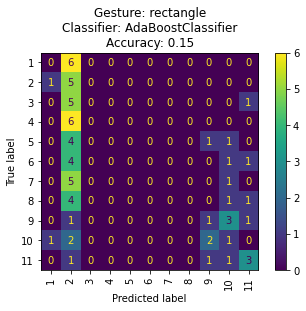

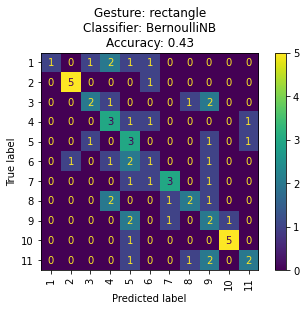

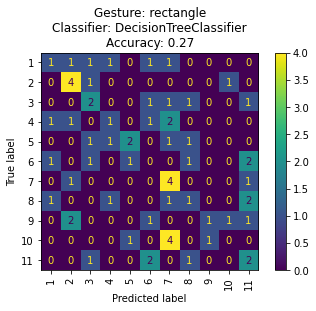

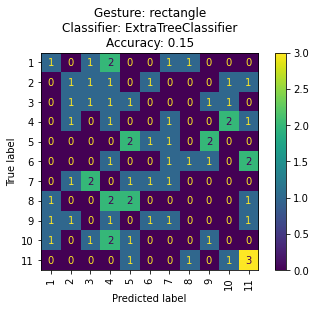

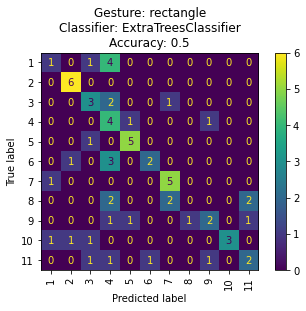

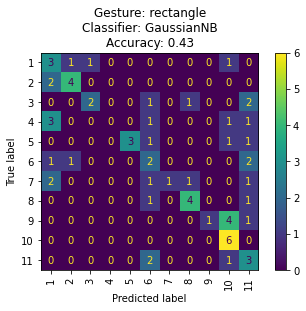

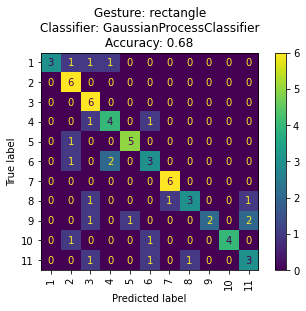

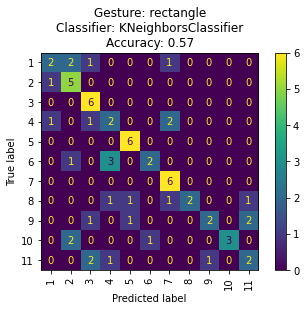

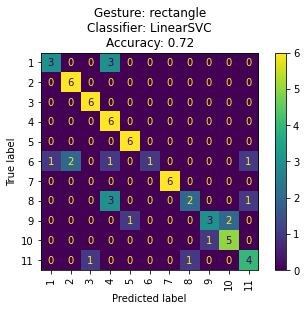

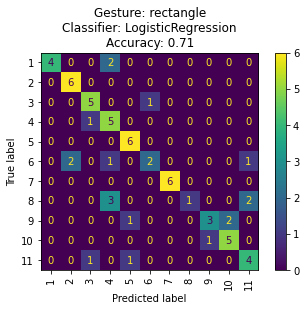

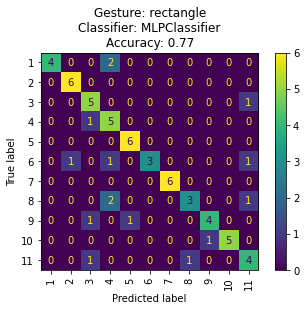

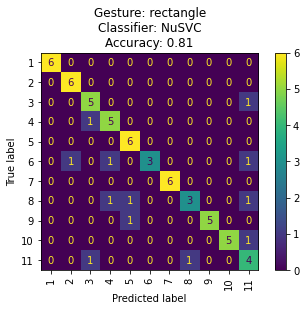

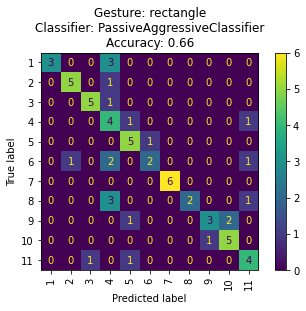

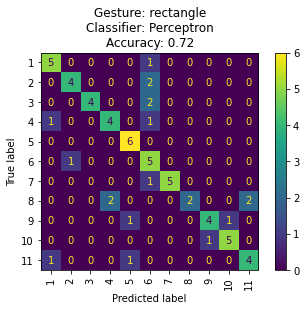

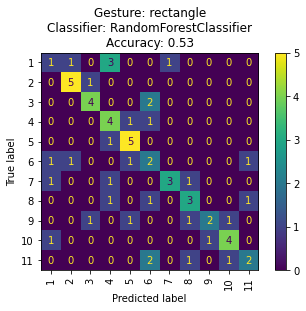

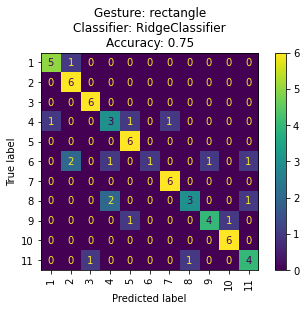

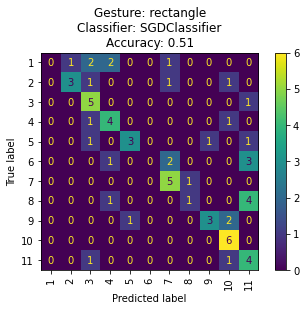

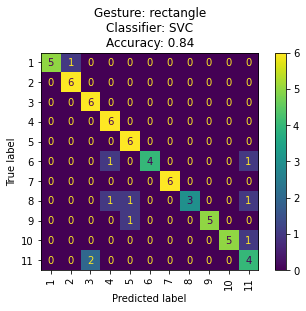

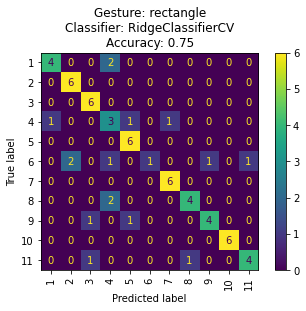

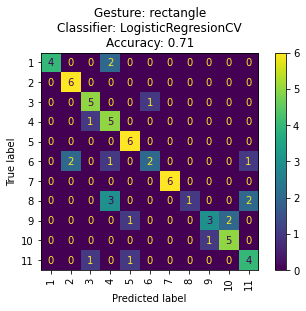

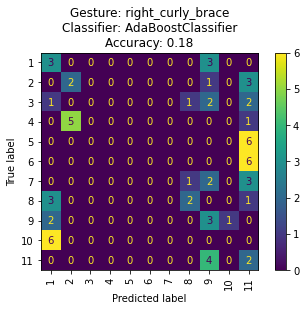

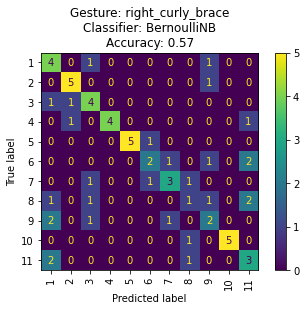

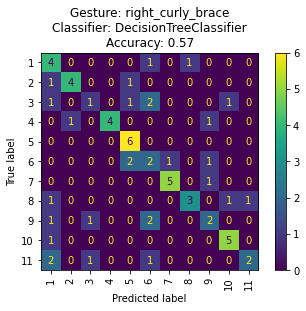

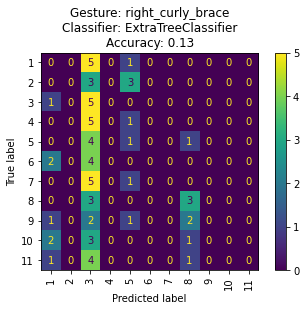

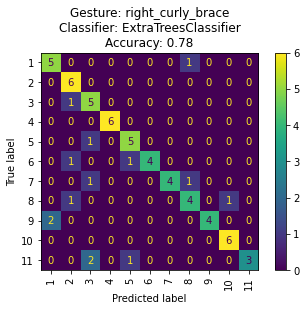

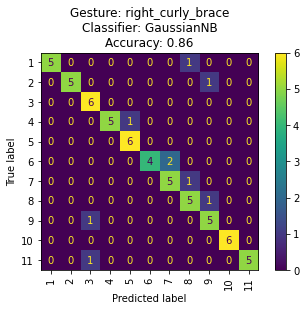

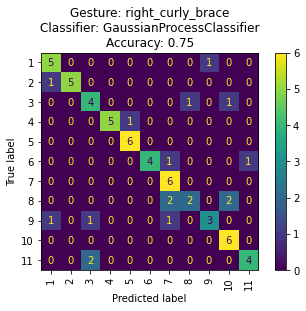

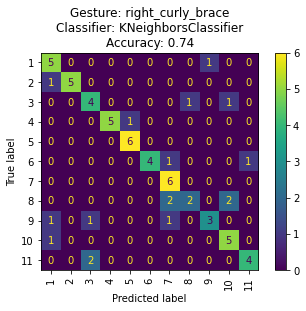

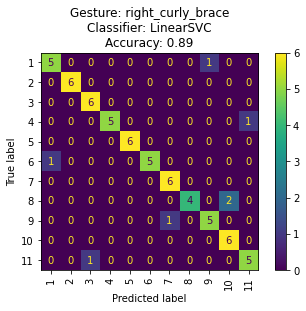

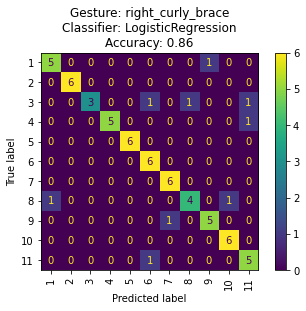

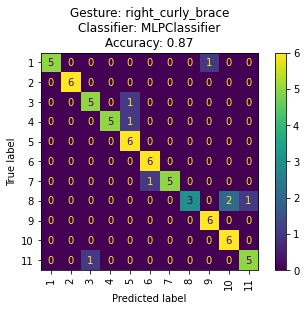

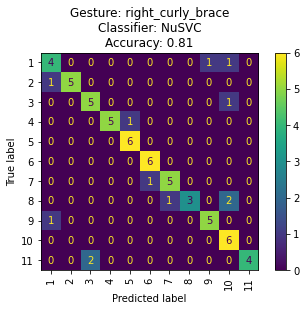

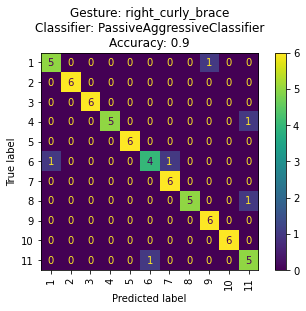

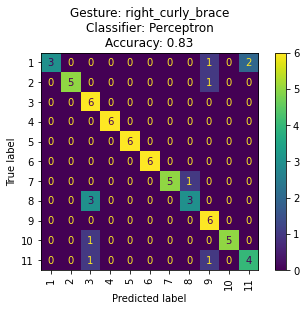

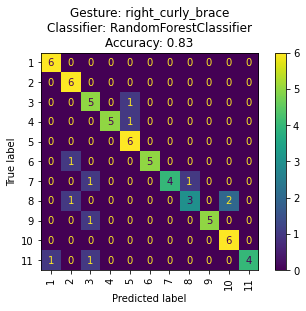

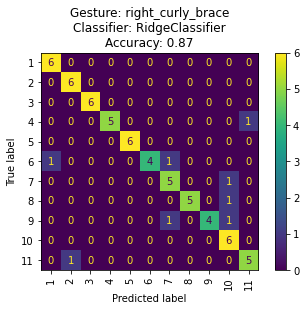

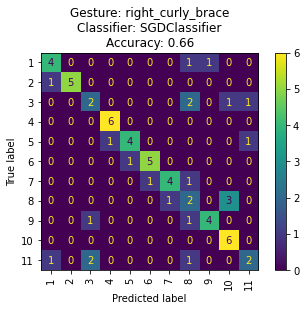

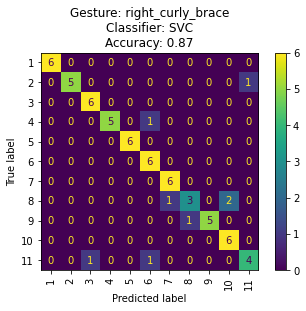

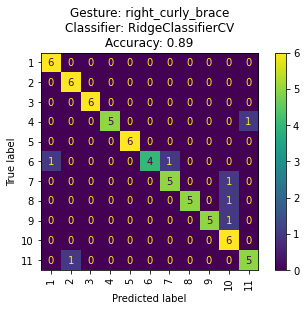

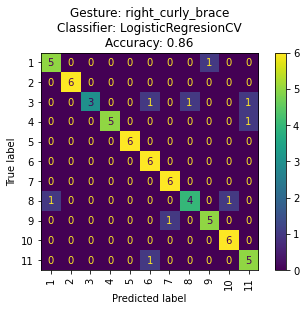

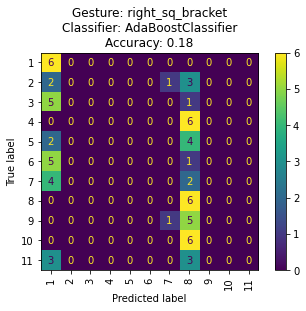

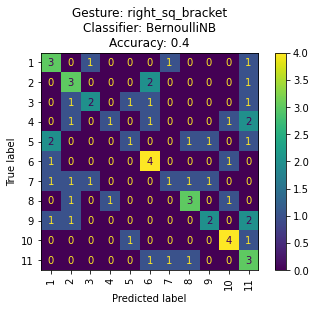

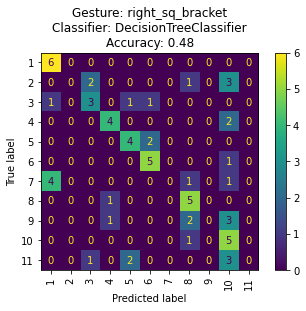

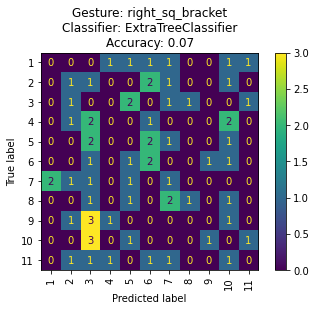

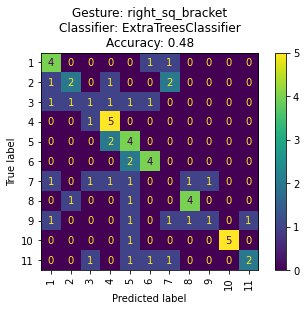

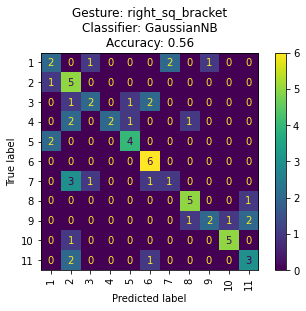

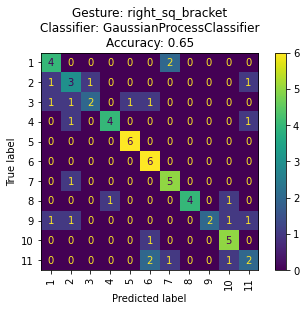

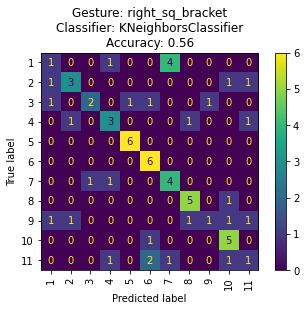

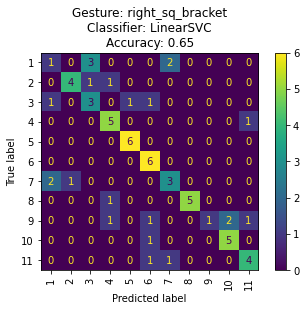

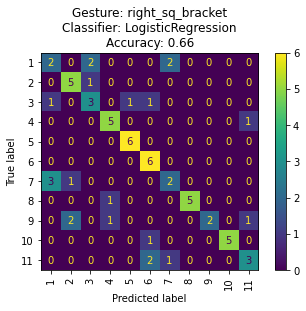

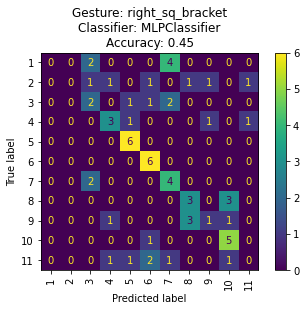

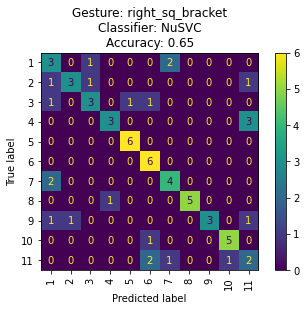

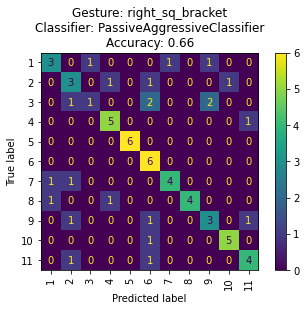

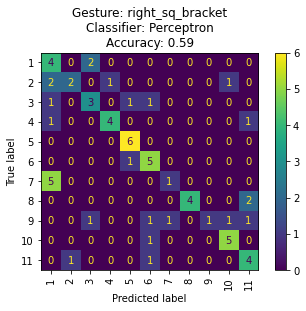

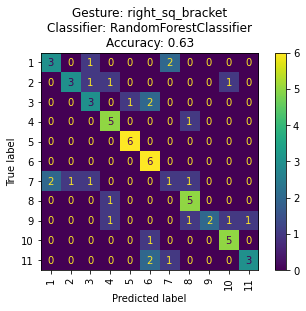

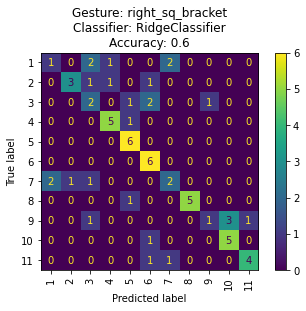

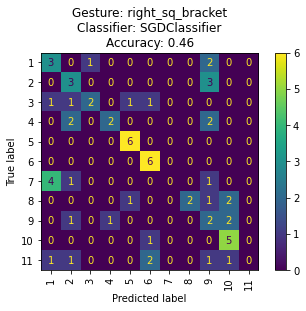

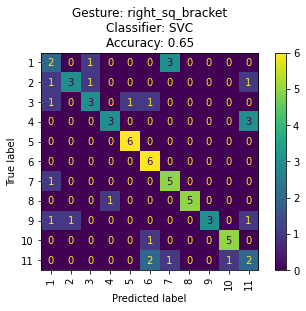

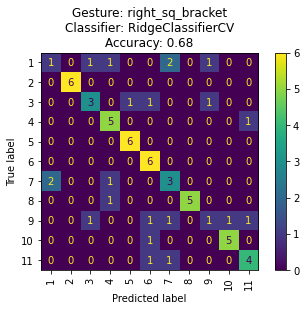

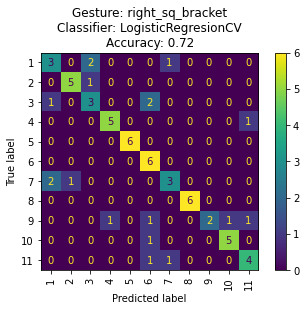

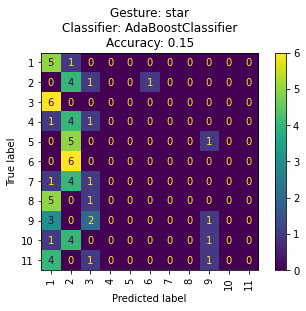

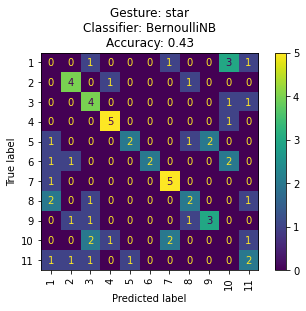

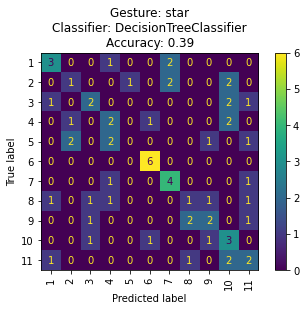

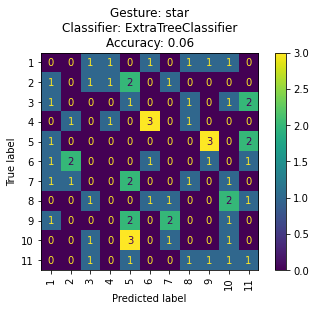

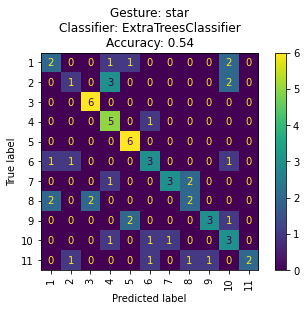

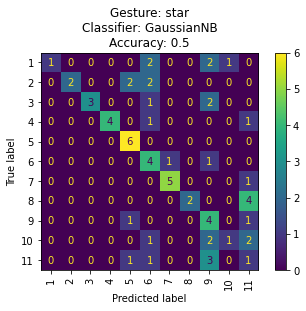

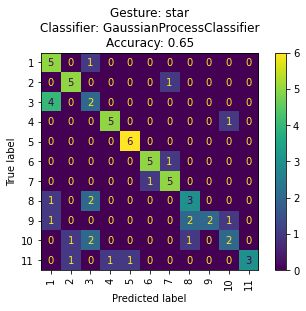

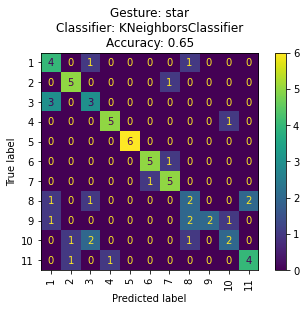

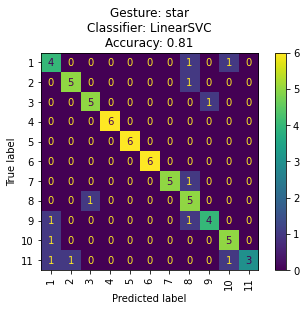

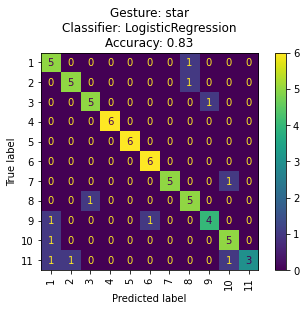

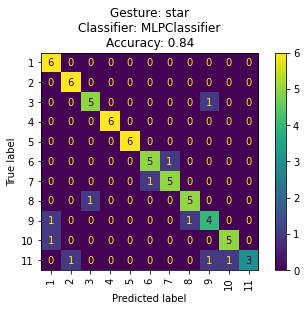

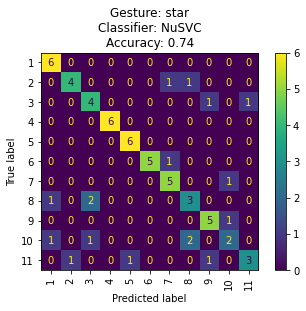

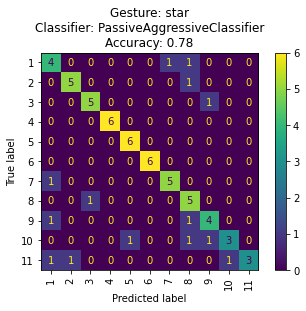

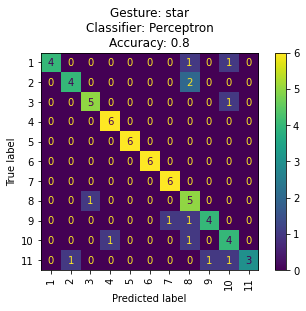

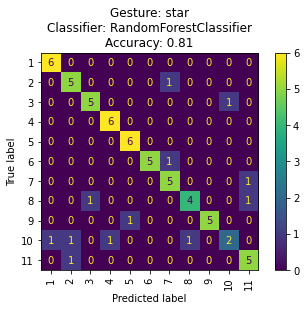

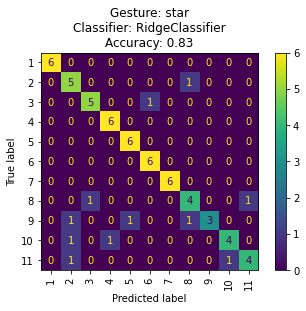

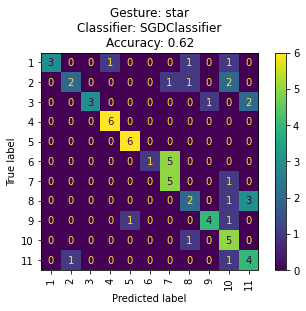

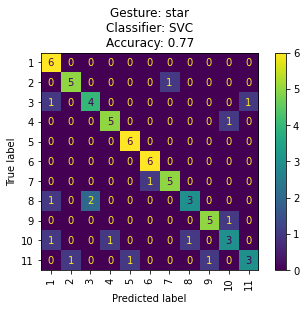

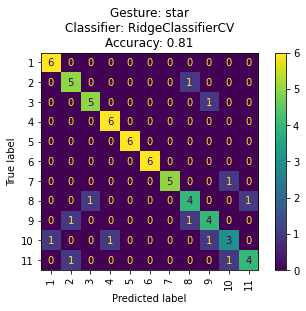

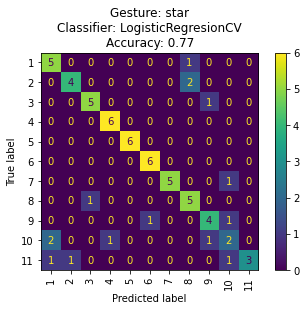

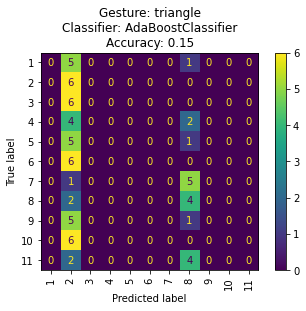

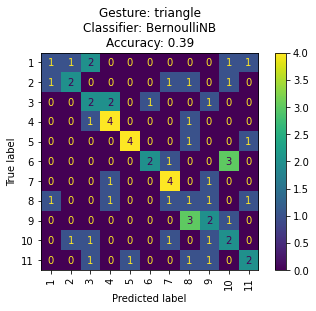

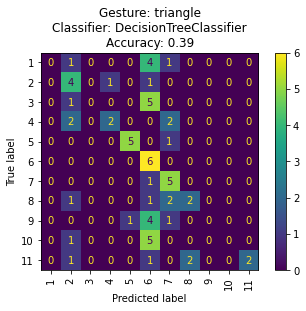

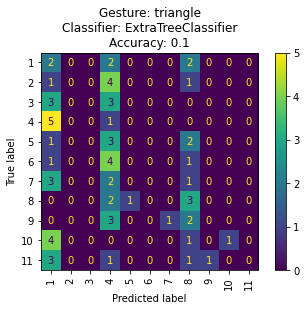

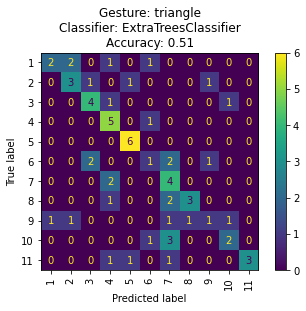

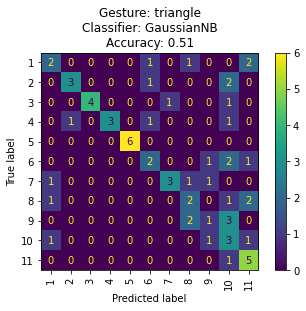

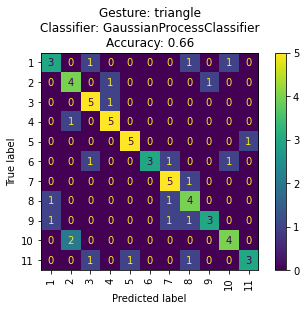

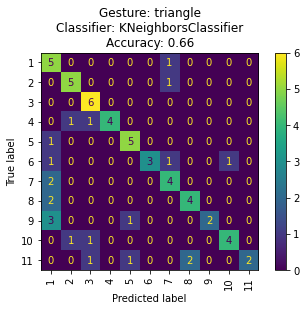

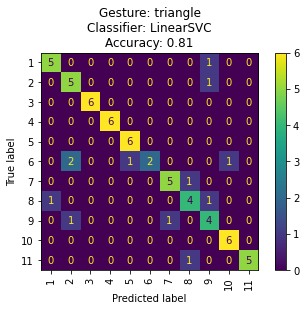

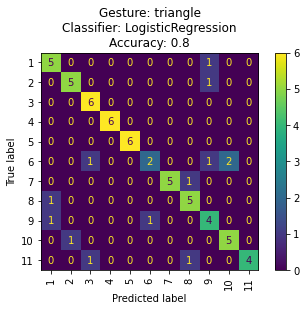

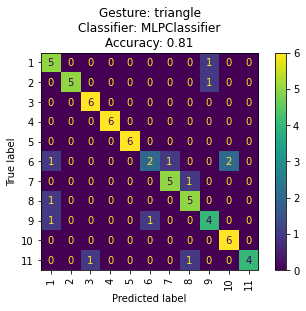

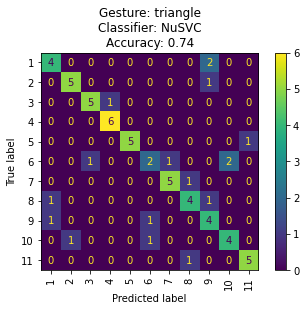

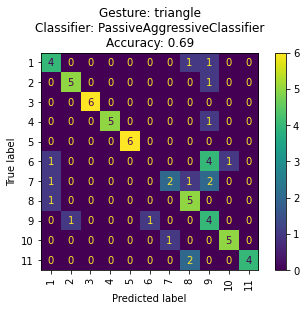

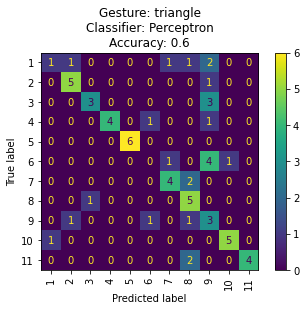

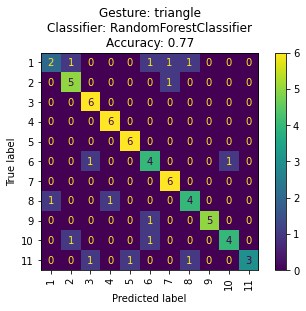

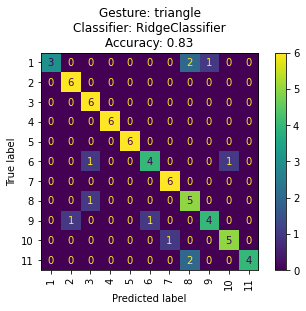

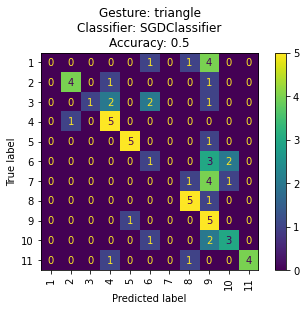

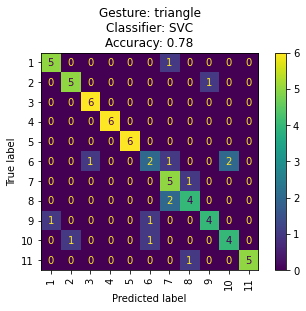

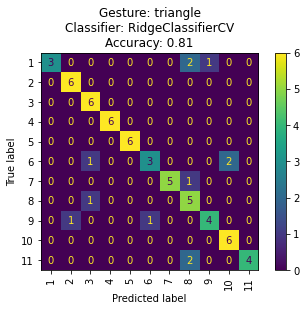

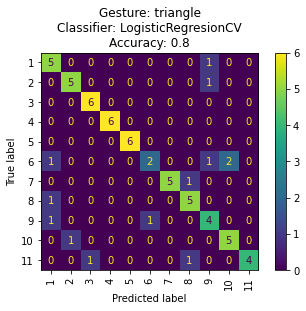

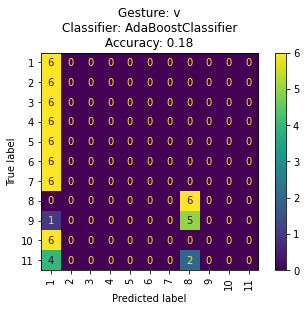

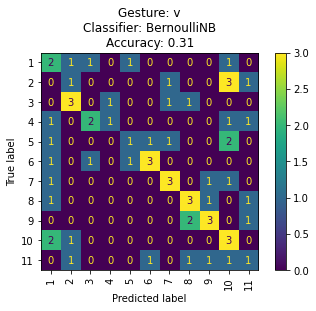

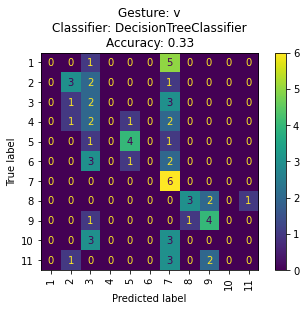

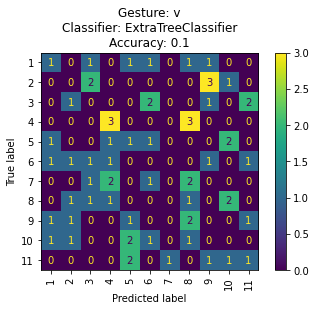

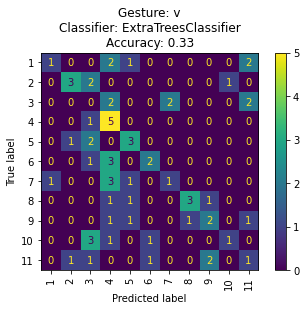

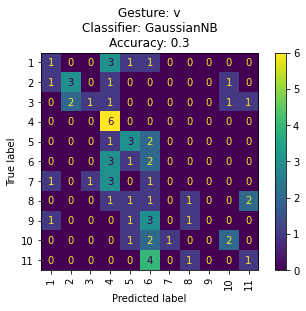

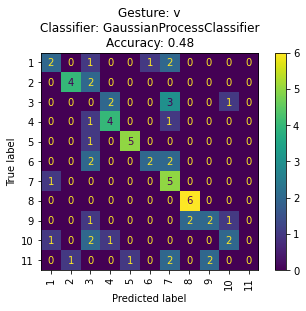

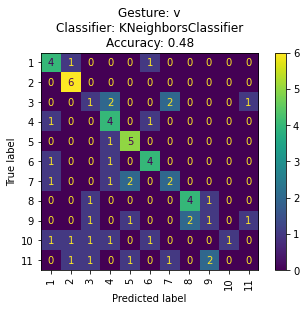

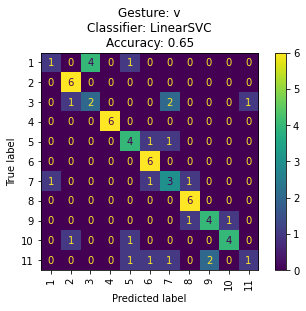

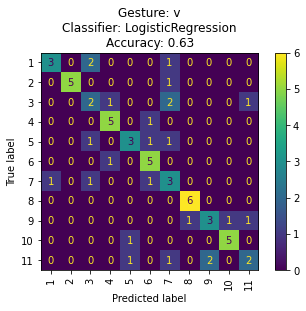

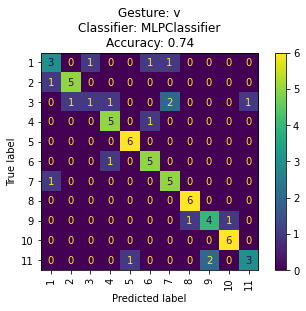

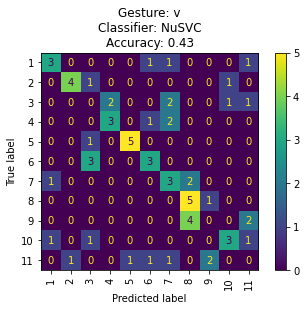

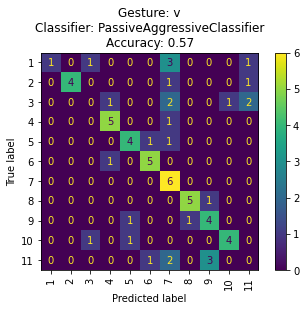

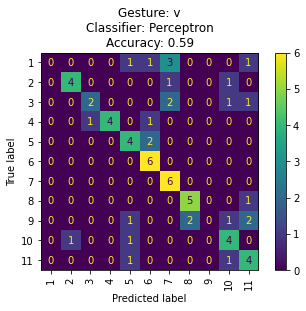

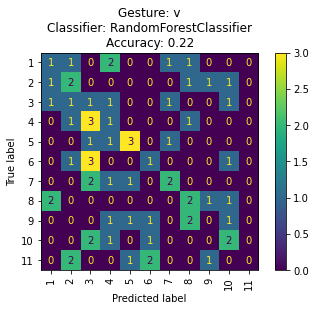

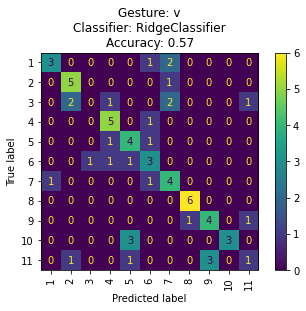

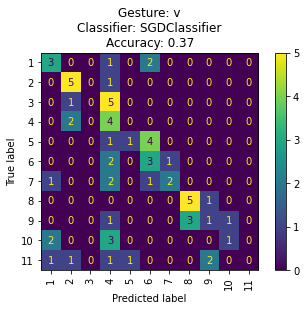

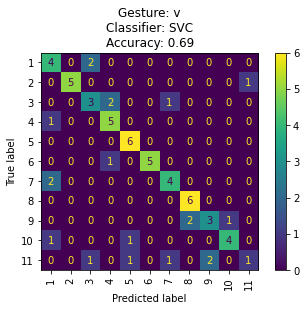

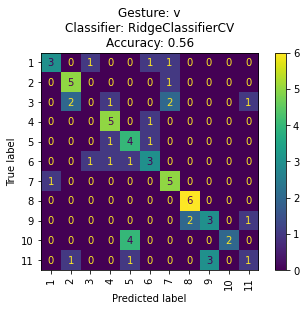

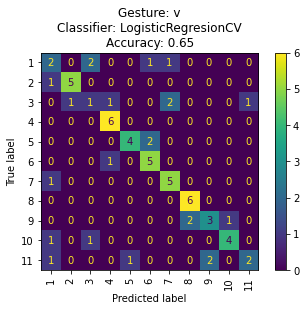

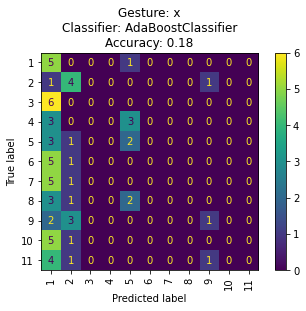

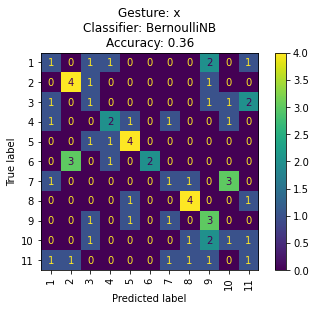

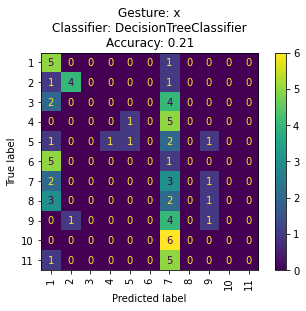

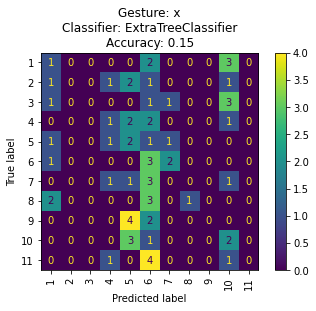

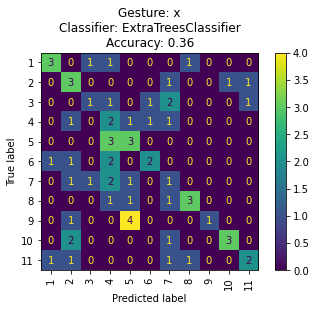

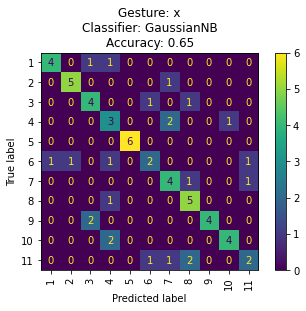

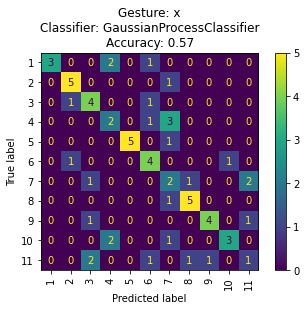

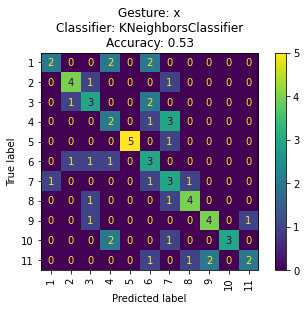

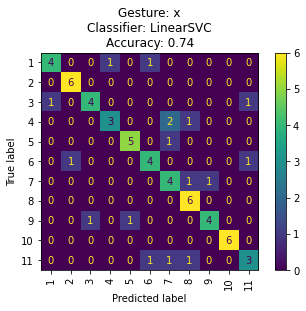

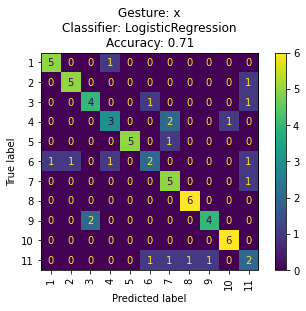

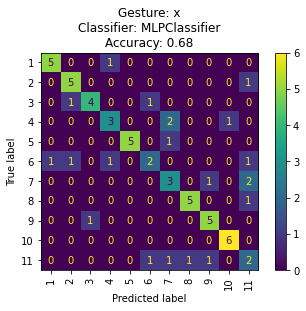

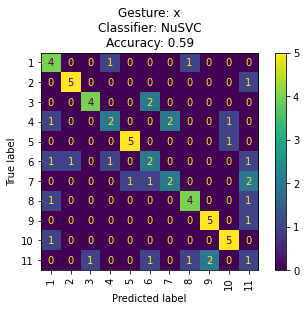

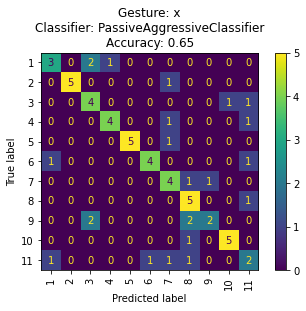

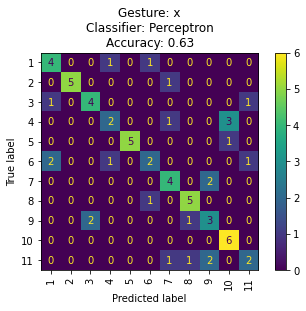

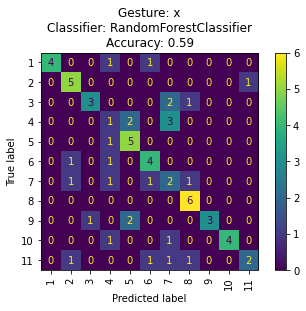

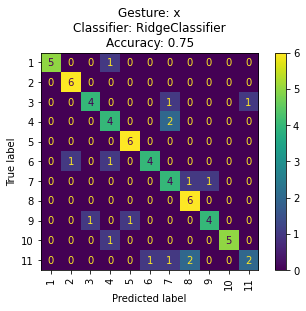

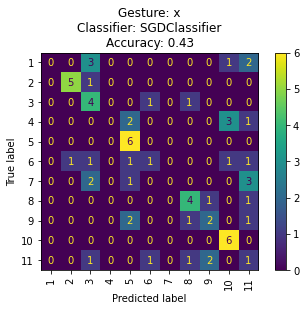

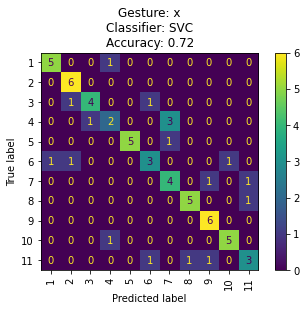

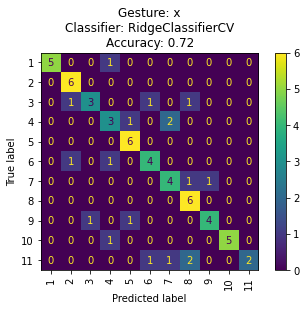

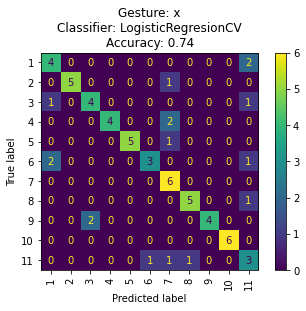

In [ ]:
for name in names:
  print(name)
  path='/content/gdrive/MyDrive/master_thesis_data/data/'
  thr=0
  X_test,X_train,y_test,y_train=data_processing(path,name)
  results=[]
  i=0
  for clf in clfs:
    model = clf()
    param_distributions = params[i]
    i=i+1
    model = HalvingRandomSearchCV(model, param_distributions).fit(X_train,y_train)
    pred=model.predict(X_test)
    model_name=slicer(clf())
    output_params=proces_params(model.best_params_)
    titles_options = ['Gesture: '+str(name)+'\n'+'Classifier: '+str(model_name)+'\n'+'Accuracy: '+str((float(int(accuracy_score(y_test, pred)*100)))/100)]
    results.append(model_name)
    results.append(str((float(int(accuracy_score(y_test, pred)*100)))/100))
    results.append(str((float(int(precision_score(y_test, pred, average='macro')*100)))/100))
    results.append(str((float(int(recall_score(y_test, pred, average='macro')*100)))/100))
    results.append(str((float(int(f1_score(y_test, pred, average='macro')*100)))/100))
    results.append(output_params)
    for title in titles_options:
      disp = plot_confusion_matrix(model, X_test, y_test,xticks_rotation='vertical') 
      disp.ax_.set_title(title)
  n=6 
  sorted_results=sorter(results,n)
  print(sorted_results)
  df_results=pd.DataFrame(sorted_results)
  df_results.to_csv('/content/gdrive/MyDrive/Master_thesis_results/Author_detection/'+name+'.csv')
  
  resultsCV=[]
  sorted_resultsCV=[]
  for clf in clfsCV:
    
    modelCV = clf()
    modelCV.fit(X_train, y_train)
    pred = modelCV.predict(X_test)
    model_nameCV=slicerCV(clf())
    print(model_nameCV)
    titles_options = ['Gesture: '+str(name)+'\n'+'Classifier: '+str(model_nameCV)+'\n'+'Accuracy: '+str((float(int(accuracy_score(y_test, pred)*100)))/100)]
    resultsCV.append(model_nameCV)
    resultsCV.append(str((float(int(accuracy_score(y_test, pred)*100)))/100))
    resultsCV.append(str((float(int(precision_score(y_test, pred, average='macro')*100)))/100))
    resultsCV.append(str((float(int(recall_score(y_test, pred, average='macro')*100)))/100))
    resultsCV.append(str((float(int(f1_score(y_test, pred, average='macro')*100)))/100))
    for title in titles_options:
      disp = plot_confusion_matrix(modelCV, X_test, y_test,xticks_rotation='vertical') 
      disp.ax_.set_title(title)
  n=5 
  sorted_resultsCV=resultsCV
  print(sorted_resultsCV)
  df_resultsCV=pd.DataFrame(sorted_resultsCV)
  df_resultsCV.to_csv('/content/gdrive/MyDrive/Master_thesis_results/Author_detection/'+name+'CV.csv')


In [ ]:
elapsed = time.time() - t
mins=int(elapsed/60)
sec=int(elapsed-mins*60)
print('Execution time: ' + str(mins)+'min '+ str(sec)+ 'sec')

Execution time: 14min 4sec
